In [1]:
import numpy as np
from scipy.stats import unitary_group

import random
from random import choices

from functools import partial
from itertools import product, combinations
from opt_einsum import contract

import tensorcircuit as tc
import qutip as qt

import jax
import jax.numpy as jnp
import jax.random as jrand
from jax import grad, jvp

from qntk_theory import KmeanTheory_RPA, K_toy, zeta_toy, lambda_toy
from qntk_theory import KstdTheoryCor_RPA, KstdTheoryInd_RPA, epsmuMeanCor_RPA, MumeanCor_RPA

import time
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=30)
rc('axes', linewidth=3)
rc('text.latex', preamble=r'\usepackage{amsfonts}')

K = tc.set_backend('jax')
tc.set_dtype('complex128')

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


('complex128', 'float64')

# Functions

## circuit build

In [113]:
def label2Pauli(label):
    # transform a string to a Pauli operator
    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    if type(label)==int:
        P = paulis[label]
    else:
        P = qt.tensor([paulis[x] for x in label])
    return P

def circuitBlockPrepare(n, L):
    # generate the Paulis and entangling layers unitary using in RPA
    random.seed(22)
    Pauligroup = list(product(range(1,4), repeat=n))
    Plabels = np.array(choices(Pauligroup, k=L), dtype=int)
    np.random.seed(22)
    Ws = unitary_group.rvs(dim=2**n, size=L)
    return Plabels, Ws

## many-body hamiltonian observables

In [37]:
def xxz_energy(circ, n, J):
    en = 0.
    # XX, YY, ZZ
    for i in range(n-1):
        en -= circ.expectation(
            (tc.gates.x(), [i]), (tc.gates.x(), [i + 1])
        )
        en -= circ.expectation(
            (tc.gates.y(), [i]), (tc.gates.y(), [i + 1])
        )
        en -= J* circ.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [i + 1])
        )
    # Z 
    for i in range(n):
        en -= J* circ.expectation((tc.gates.z(), [i]))

    return K.real(en)

def tfim_energy(circ, n, h):
    # tfim energy
    en = 0
    for i in range(n):
        en -= h * circ.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n - 1):  # OBC
        en -= circ.expectation((tc.gates.z(), [i]), (tc.gates.z(), [(i + 1) % n])
        )  # <Z_iZ_{i+1}>
    return K.real(en)

In [ ]:
def RPA_xxz(thetas, circ, n, Xs, Ws, J):
    L = len(Xs)
    # circuit
    for l in range(L):
        circ.exp1(*range(n), theta=thetas[l], hermitian=Xs[l], half=True)
        circ.any(*range(n), unitary=Ws[l])
    
    # xxz energy
    en = xxz_energy(circ, n, J)
    return en

def RPAtraining_xxz(n, L, batch, eta, steps, O0, J, intercept=1, tend=1001, display_time=100):
    key = jrand.PRNGKey(42)
    thetas = jrand.uniform(key, shape=(batch, L))*(2.*np.pi)

    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    circ = tc.Circuit(n)
    energy_vag = K.jit(K.value_and_grad(partial(RPA_xxz, circ=circ, n=n, Xs=Xs, Ws=Ws, J=J)))
    energy_vvag = K.jit(K.vmap(energy_vag, vectorized_argnums=0))
    
    eps_hist = jnp.zeros((steps, batch))
    K_hist = jnp.zeros((steps, batch))
    thetas_hist = jnp.zeros((tend//intercept+2, batch, L))
    
    t0 = time.time()

    for step in range(steps):
        Es, Js = energy_vvag(thetas)
        epss = Es - O0
        Ks = jnp.sum(Js **2, axis=1)
        grad_loss = contract('r, ri->ri', epss, Js)
        eps_hist = eps_hist.at[step].set(epss)
        K_hist = K_hist.at[step].set(Ks)

        if (step % intercept == 0) and (step < tend):
            thetas_hist = thetas_hist.at[step//intercept].set(thetas)

        thetas = thetas - eta* grad_loss
        if step % display_time == 0:
            print(f"Step {step}, epsilon: {epss}, time elapsed: {time.time()-t0} seconds")
    
    thetas_hist = thetas_hist.at[-1].set(thetas)

    return eps_hist, K_hist, thetas_hist

In [333]:
def RPAtraining_xxz_linear(n, L, batch, eta, steps, J, intercept=1, tend=1001, display_time=100):
    key = jrand.PRNGKey(42)
    thetas = jrand.uniform(key, shape=(batch, L))*(2.*np.pi)

    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    circ = tc.Circuit(n)
    energy_vag = K.jit(K.value_and_grad(partial(RPA_xxz, circ=circ, n=n, Xs=Xs, Ws=Ws, J=J)))
    energy_vvag = K.jit(K.vmap(energy_vag, vectorized_argnums=0))
    
    E_hist = jnp.zeros((steps, batch))
    K_hist = jnp.zeros((steps, batch))
    thetas_hist = jnp.zeros((tend//intercept+2, batch, L))
    
    t0 = time.time()

    for step in range(steps):
        Es, Js = energy_vvag(thetas)
        Ks = jnp.sum(Js **2, axis=1)
        E_hist = E_hist.at[step].set(Es)
        K_hist = K_hist.at[step].set(Ks)

        if (step % intercept == 0) and (step < tend):
            thetas_hist = thetas_hist.at[step//intercept].set(thetas)

        thetas = thetas - eta* Js
        if step % display_time == 0:
            print(f"Step {step}, epsilon: {Es}, time elapsed: {time.time()-t0} seconds")
    
    thetas_hist = thetas_hist.at[-1].set(thetas)

    return E_hist, K_hist, thetas_hist

## state preparation

In [40]:
def RPA_state(thetas, circ, n, Xs, Ws, target):
    L = len(Xs)
    # circuit
    for l in range(L):
        circ.exp1(*range(n), theta=thetas[l], hermitian=Xs[l], half=True)
        circ.any(*range(n), unitary=Ws[l])
    
    output = circ.state()
    return K.abs(target.conj() @ output)**2

def RPAtraining_state(n, L, batch, eta, steps, target, O0, display_time=100):
    key = jrand.PRNGKey(42)
    thetas = jrand.uniform(key, shape=(batch, L))*(2.*np.pi)

    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    circ = tc.Circuit(n)
    fid_vag = K.jit(K.value_and_grad(partial(RPA_state, circ=circ, n=n, Xs=Xs, Ws=Ws, target=target)))
    fid_vvag = K.jit(K.vmap(fid_vag, vectorized_argnums=0))

    eps_hist = jnp.zeros((steps, batch))
    K_hist = jnp.zeros((steps, batch))
    thetas_hist = jnp.zeros((2, batch, L))

    t0 = time.time()
    for step in range(steps):
        fs, Js = fid_vvag(thetas)
        epss = fs-O0

        Ks = jnp.sum(Js **2, axis=1)
        grad_loss = contract('r, ri->ri', epss, Js)
        eps_hist = eps_hist.at[step].set(epss)
        K_hist = K_hist.at[step].set(Ks)

        thetas = thetas - eta* grad_loss
        if step % display_time == 0:
            print(f"Step {step}, epsilon: {epss}, time elapsed: {time.time()-t0} seconds")
    
    thetas_hist = thetas_hist.at[1].set(thetas)
    
    return eps_hist, K_hist, thetas_hist

## dQNTK calculation

In [143]:
def muEval_xxz(thetas, n, L, J):
    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    # calculate gradient
    energy_g = K.jit(K.grad(partial(RPA_xxz, circ=tc.Circuit(n), n=n, Xs=Xs, Ws=Ws, J=J)))
    energy_g_batch = K.jit(K.vmap(energy_g))
    vs = energy_g_batch(thetas)

    # calculate hessian.gradient
    hvp_batch = K.jit(lambda thetas, vs: K.jvp(energy_g_batch, (thetas, ), (vs, )))
    hgs = hvp_batch(thetas, vs)[1]
    mus = contract('ri, ri->r', vs, hgs)
    
    return mus

def muEval_state(thetas, n, L, target):
    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    # calculate gradient
    fid_g = K.jit(K.grad(partial(RPA_state, circ=tc.Circuit(n), n=n, Xs=Xs, Ws=Ws, target=target)))
    fid_g_batch = K.jit(K.vmap(fid_g))
    vs = fid_g_batch(thetas)

    # calculate hessian.gradient
    hvp_batch = K.jit(lambda thetas, vs: K.jvp(fid_g_batch, (thetas, ), (vs, )))
    hgs = hvp_batch(thetas, vs)[1]
    mus = contract('ri, ri->r', vs, hgs)
    
    return mus

## many-body hamiltonians

In [3]:
# XXZ model
def xxz(n, J):
    Hxxz = 0
    # one-body
    for i in range(n):
        Hxxz -= J* qt.tensor([qt.sigmaz() if i==j else qt.qeye(2) for j in range(n)])
    # two-body
    for i in range(n-1):
        Hxxz -= qt.tensor([qt.sigmax() if (j==i or j==i+1) else qt.qeye(2) for j in range(n)])
        Hxxz -= qt.tensor([qt.sigmay() if (j==i or j==i+1) else qt.qeye(2) for j in range(n)])
        Hxxz -= J* qt.tensor([qt.sigmaz() if (j==i or j==i+1) else qt.qeye(2) for j in range(n)])
    
    return Hxxz


# TFIM model
def tfim(n, h):
    Htfim = 0
    for i in range(n):
        Htfim -= h*qt.tensor([qt.sigmax() if i==j else qt.qeye(2) for j in range(n)])

    for i in range(n-1):
        Htfim -= qt.tensor([qt.sigmaz() if (j==i or j==i+1) else qt.qeye(2) for j in range(n)])
    return Htfim

In [348]:
Hxxz = xxz(10, 2)
Hxxz.groundstate()[0]

-38.0

# Results

## Dynamics

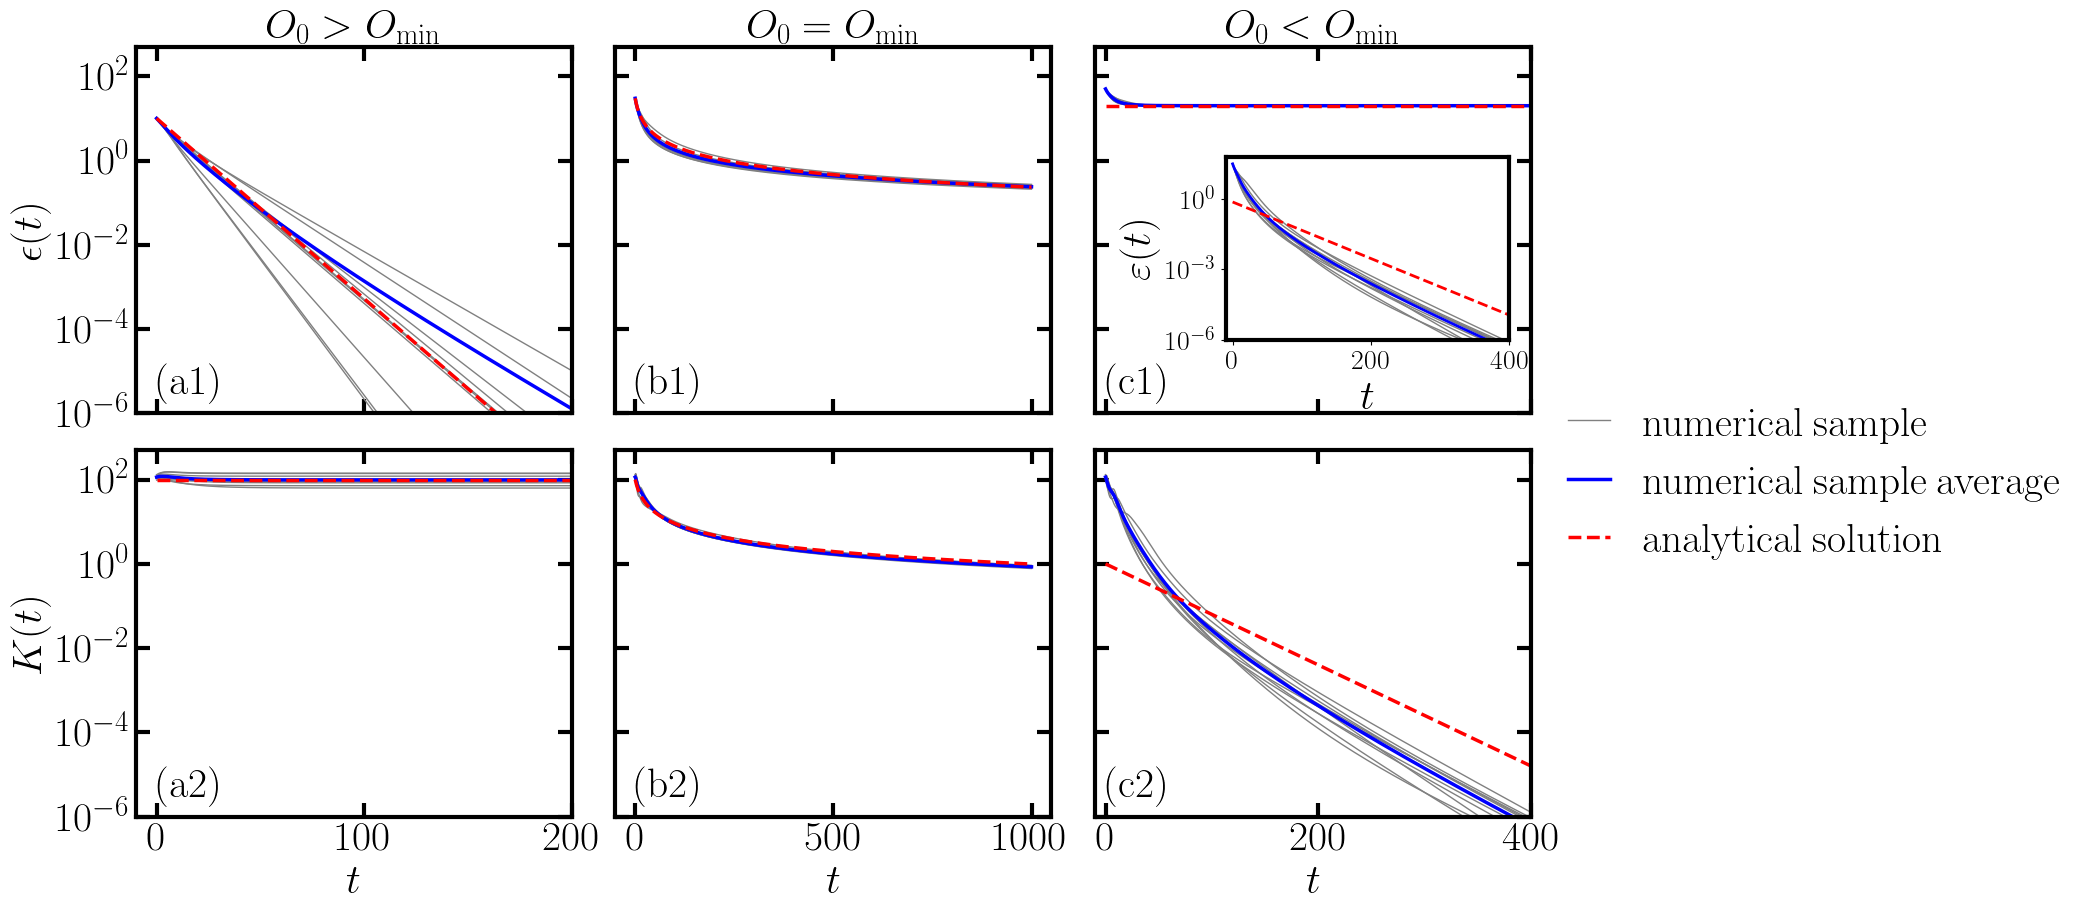

In [4]:
n = 8
O = xxz(n, 2)
O0_list = [-10, -30, -50]
eta = 1e-3
L = 2**8 * 3

ts = np.arange(1001)
eps_list = np.zeros((3, 1001, 10))
K_list = np.zeros((3, 1001, 10))
for i in range(3):
    eps_list[i] = np.load(f'data/training/RPA/Heisenberg/n{n}/RPAepshistXXZ_n{n}L{L}Tgt{O0_list[i]}.npy')
    K_list[i] = np.load(f'data/training/RPA/Heisenberg/n{n}/RPAKhistXXZ_n{n}L{L}Tgt{O0_list[i]}.npy')
mus = np.zeros((3, 10))
for i in range(3):
    mus[i] = np.load(f'data/training/RPA/Heisenberg/n{n}/RPAmuinfXXZ_n{n}L{L}Tgt{O0_list[i]}.npy')
ldas = np.mean(mus, axis=1)/np.mean(K_list[:,-1], axis=1)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0,0].plot(ts, eps_list[0, :, 0], lw=1, c='grey', label=r'$\rm numerical\: sample$')
for i in range(9):
    axs[0,0].plot(ts, eps_list[0, :, i+1], lw=1, c='grey')
axs[0,0].plot(ts, np.mean(eps_list[0], axis=1), lw=2.5, c='b', label=r'$\rm numerical\: sample\: average$')
axs[0,0].plot(ts, 10*np.exp(-eta* np.mean(K_list[0,-1])*ts), '--', lw=2.5, c='r', label=r'$\rm analytical\:solution$')
axs[0,0].set_ylim(1e-6, 100)
axs[0,0].set_xlim(-10, 200)

axs[1,0].plot(ts, K_list[0], lw=1, c='grey')
axs[1,0].plot(ts, np.mean(K_list[0], axis=1), lw=2.5, c='b')
axs[1,0].plot(ts, np.mean(K_list[0,-1])*np.ones(1001), '--', lw=2.5, c='r')
axs[1,0].set_xlim(-10, 200)

axs[0,1].plot(ts, eps_list[1], lw=1, c='grey')
axs[0,1].plot(ts, np.mean(eps_list[1], axis=1), lw=2.5, c='b')
axs[0,1].plot(ts, 1/(2*ldas[1]*eta*ts + 1/30), '--', lw=2.5, c='r')

axs[1,1].plot(ts, K_list[1], lw=1, c='grey')
axs[1,1].plot(ts, np.mean(K_list[1], axis=1), lw=2.5, c='b')
axs[1,1].plot(ts, 1/(eta*ts + 1/100), '--', lw=2.5, c='r')

axs[0,2].plot(ts, eps_list[2], lw=1, c='grey')
axs[0,2].plot(ts, np.mean(eps_list[2], axis=1), lw=2.5, c='b')
R = O0_list[1]-O0_list[2]
C = -2*ldas[2]*R
axs[0,2].plot(ts, R*np.ones(1001), '--', lw=2.5, c='r')
axs[0,2].set_xlim(-10, 400)

# varepsilon
inset_ax = axs[0,2].inset_axes([0.3, 0.2, 0.65, 0.5])
inset_ax.plot(ts, eps_list[2] - R, lw=1, c='grey')
inset_ax.plot(ts, np.mean(eps_list[2], axis=1) - R, lw=2, c='b')
inset_ax.plot(ts, np.exp(eta * C * ts)/(2*ldas[2]), '--', lw=2, c='r')
inset_ax.set_xlabel(r'$t$')
inset_ax.set_ylabel(r'$\varepsilon(t)$')
inset_ax.set_yscale('log')
inset_ax.set_ylim(1e-6, 60)
inset_ax.set_xticks([0, 200, 400])
inset_ax.set_yticks([1e-6, 1e-3, 1])
inset_ax.set_xlim(-10, 400)
inset_ax.tick_params(labelsize=20)

axs[1,2].plot(ts, K_list[2], lw=1, c='grey')
axs[1,2].plot(ts, np.mean(K_list[2], axis=1), lw=2.5, c='b')
axs[1,2].plot(ts, np.exp(eta * C * ts), '--', lw=2.5, c='r')
axs[1,2].set_xlim(-10, 400)

axs[0,0].set_ylabel(r'$\epsilon(t)$')
axs[1,0].set_ylabel(r'$K(t)$')

compare_ops = ['>', '=', '<']
for i in range(3):
    axs[0, i].set_ylim(1e-6, 500)
    axs[1, i].set_ylim(1e-6, 500)
    axs[0, i%3].set_xticklabels([])
    axs[1, i].set_xlabel(r'$t$', fontsize=30)
    axs[0, i].set_title(r'$O_0%s O_{\rm min}$'%compare_ops[i], fontsize=30)
    axs[0, i].text(x=0, y=3e-6, s=r'$\rm (%s1)$'%(chr(i + ord('a'))), fontsize=30)
    axs[1, i].text(x=0, y=3e-6, s=r'$\rm (%s2)$'%(chr(i + ord('a'))), fontsize=30)

for i in range(6):
    axs[i//3, i%3].set_yscale('log')
    if i%3:
        axs[i//3, i%3].set_yticklabels([])
    axs[i//3, i%3].tick_params(direction='in', length=10, width=3, top='on', right='on')

axs[0, 0].legend(loc='lower left', bbox_to_anchor=(3.2, -0.5), framealpha=0, handlelength=1)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Flow diagram

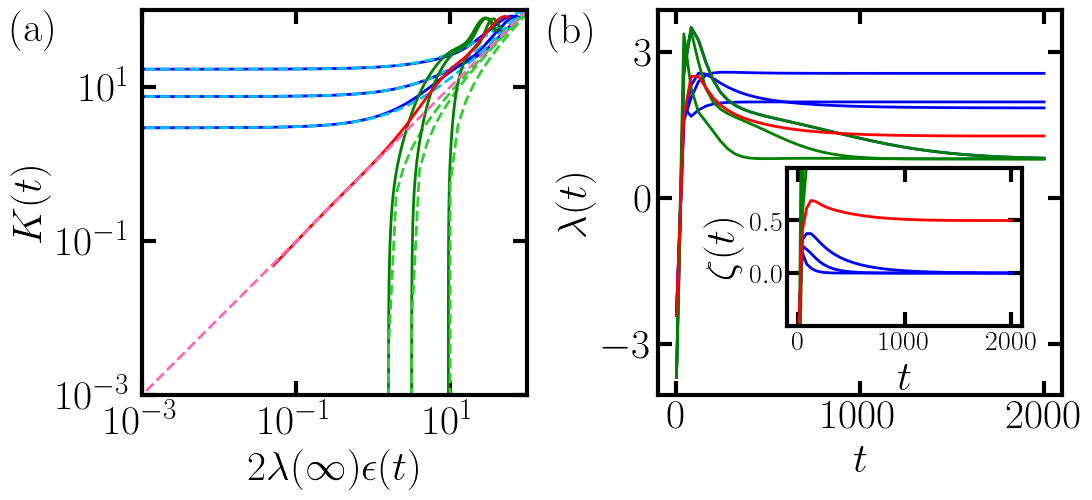

In [292]:
n = 6
L = 3*2**n
O0s = [-18, -20, -21, -23, -24, -28, -22]

ids = [0, 0, 0, 2, 2, 2, 0]
eps_hist = []
K_hist = []
mu_hist = []
ldas = np.zeros(len(O0s))
Cs = np.zeros(len(O0s))
for i in range(len(O0s)):
    idx = ids[i]
    eps_each = np.load(f'data/training/RPA/Heisenberg/n{n}/RPAepshistXXZ_n{n}L{L}Tgt{O0s[i]}.npy')[:,idx]
    K_each = np.load(f'data/training/RPA/Heisenberg/n{n}/RPAKhistXXZ_n{n}L{L}Tgt{O0s[i]}.npy')[:,idx]
    mu_each = np.load(f'data/training/RPA/Heisenberg/n{n}/RPAmuhistXXZ_n{n}L{L}Tgt{O0s[i]}.npy')[:,idx]
    eps_hist.append(eps_each)
    K_hist.append(K_each)
    mu_hist.append(mu_each)

    ldas[i] = mu_each[-1]/K_each[-1]
    Cs[i] = K_each[-1] - 2*ldas[i]*eps_each[-1]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_aspect('equal')
x = 2*10.**np.arange(-4.6, 2.4, 0.1)
for i in range(3):
    axs[0].plot(2*ldas[i]*eps_hist[i], K_hist[i], c='b', lw=2)
    axs[0].plot(x, Cs[i] + x, '--', c='deepskyblue', lw=2)

for i in range(3,6):
    axs[0].plot(2*ldas[i]*eps_hist[i], K_hist[i], c='g', lw=2)
    axs[0].plot(x, Cs[i] + x, '--', c='limegreen', lw=2)

axs[0].plot(2*ldas[-1]*eps_hist[-1], K_hist[-1], c='r', lw=2)
axs[0].plot(x, x, '--', c='hotpink', lw=2)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlim(1e-3, 100)
axs[0].set_ylim(1e-3, 100)
axs[0].set_xlabel(r'$2\lambda(\infty) \epsilon(t)$')
axs[0].set_ylabel(r'$K(t)$')
axs[0].tick_params(direction='in', length=10, width=3, top='on', right='on', pad=8)

for i in range(4):
    axs[1].plot(np.arange(0, 2001, 40), mu_hist[i][:-1]/K_hist[i][:2001:40], c='b', lw=2)
for i in range(3, 6):
    axs[1].plot(np.arange(0, 2001, 40), mu_hist[i][:-1]/K_hist[i][:2001:40], c='g', lw=2)
axs[1].plot(np.arange(0, 2001, 40), mu_hist[-1][:-1]/K_hist[-1][:2001:40], c='r', lw=2)
axs[1].set_xlabel(r'$t$')
axs[1].set_ylabel(r'$\lambda(t)$')
axs[1].set_xticks(np.arange(3)*1e3)
axs[1].set_yticks([-3,0,3])
axs[1].tick_params(direction='in', length=10, width=3, top='on', right='on')

inset_ax = axs[1].inset_axes([0.32, 0.18, 0.58, 0.41])
for i in range(3):
    inset_ax.plot(np.arange(0, 2001, 40), eps_hist[i][:2001:40]*mu_hist[i][:-1]/K_hist[i][:2001:40]**2, 
                  c='b', lw=2)
for i in range(3, 6):
    inset_ax.plot(np.arange(0, 2001, 40), eps_hist[i][:2001:40]*mu_hist[i][:-1]/K_hist[i][:2001:40]**2, 
                  c='g', lw=2)
inset_ax.plot(np.arange(0, 2001, 40), eps_hist[-1][:2001:40]*mu_hist[-1][:-1]/K_hist[-1][:2001:40]**2, 
                  c='r', lw=2)
inset_ax.set_xlabel(r'$t$')
inset_ax.set_ylabel(r'$\zeta(t)$')
inset_ax.set_ylim(-0.5, 1.)
inset_ax.set_yticks([0, 0.5])
inset_ax.set_xticks(np.arange(3)*1e3)
inset_ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=20)

axs[0].text(x=2e-5, y=40, s=r'$\rm (a)$', fontsize=30)
axs[1].text(x=-700., y=3.2, s=r'$\rm (b)$', fontsize=30)

plt.subplots_adjust(wspace=0.3)

## finite-depth effect

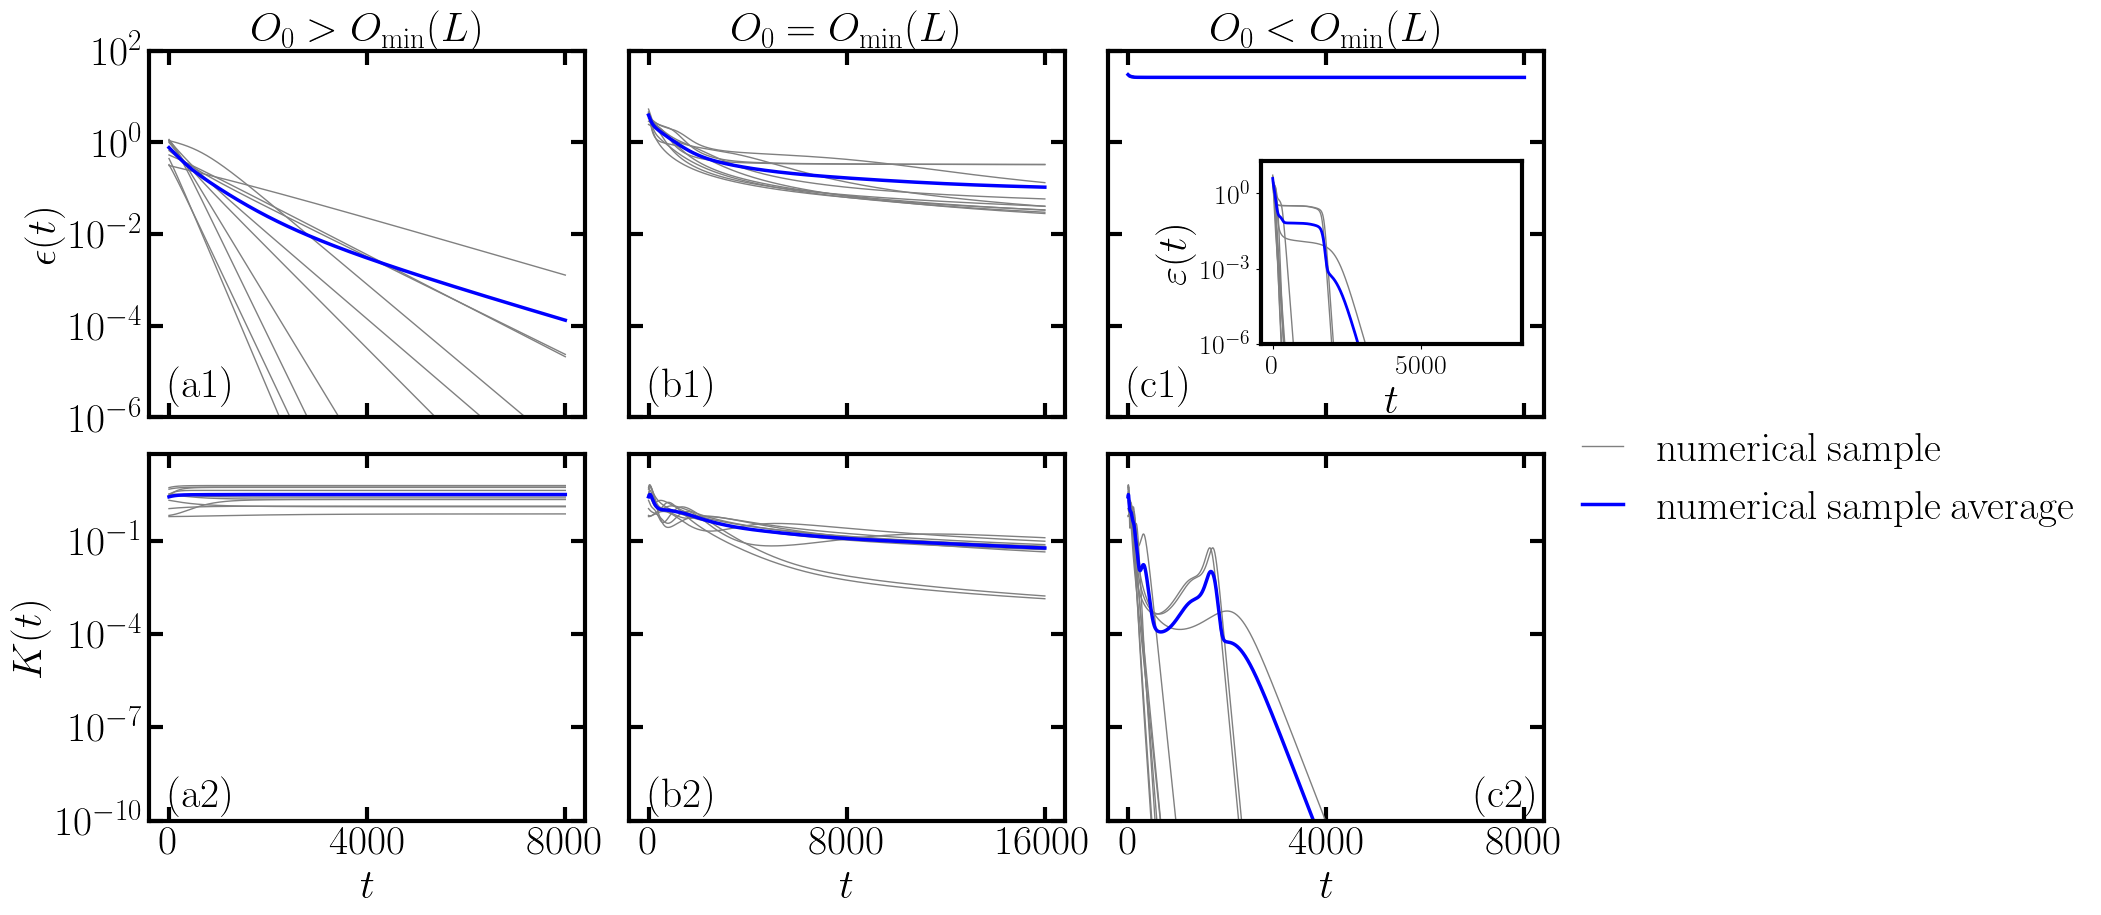

In [357]:
n = 6
L = 6

O0_list = [-0.2, 'c', -30]
eps_list = []
K_list = []
for i in range(3):
    eps_list.append(np.load(f'data/training/RPA/Heisenberg/n{n}/finite/RPAepshistXXZ_n{n}L{L}Tgt{O0_list[i]}.npy'))
    K_list.append(np.load(f'data/training/RPA/Heisenberg/n{n}/finite/RPAKhistXXZ_n{n}L{L}Tgt{O0_list[i]}.npy'))

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs[0,0].plot(np.abs(eps_list[0][:, 0]), lw=1, c='grey', label=r'$\rm numerical\:sample$')
for i in range(9):
    axs[0,0].plot(np.abs(eps_list[0][:, i+1]), lw=1, c='grey')
axs[0,0].plot(np.mean(np.abs(eps_list[0]), axis=1), lw=2.5, c='b', label=r'$\rm numerical\:sample\:average$')
axs[0,0].set_xticks(np.arange(3)*4000)

axs[1,0].plot(K_list[0], lw=1, c='grey')
axs[1,0].plot(np.mean(K_list[0], axis=1), lw=2.5, c='b')
axs[1,0].set_xticks(np.arange(3)*4000)

axs[0,1].plot(eps_list[1][:16000], lw=1, c='grey')
axs[0,1].plot(np.mean(eps_list[1][:16000], axis=1), lw=2.5, c='b')
axs[0,1].set_xticks(np.arange(3)*8000)

axs[1,1].plot(K_list[1][:16000], lw=1, c='grey')
axs[1,1].plot(np.mean(K_list[1][:16000], axis=1), lw=2.5, c='b')
axs[1,1].set_xticks(np.arange(3)*8000)

axs[0,2].plot(eps_list[2], lw=1, c='grey')
axs[0,2].plot(np.mean(eps_list[2], axis=1), lw=2.5, c='b')
axs[0,2].set_xticks(np.arange(3)*4000)

# varepsilon
inset_ax = axs[0,2].inset_axes([0.35, 0.2, 0.6, 0.5])
inset_ax.plot(eps_list[2][:len(eps_list[2])] - eps_list[2][-1], lw=1, c='grey')
inset_ax.plot(np.mean(eps_list[2][:len(eps_list[2])] - eps_list[2][-1], axis=1), lw=2, c='b')
inset_ax.set_xlabel(r'$t$')
inset_ax.set_ylabel(r'$\varepsilon(t)$')
inset_ax.set_yscale('log')
inset_ax.set_ylim(1e-6, 20)
inset_ax.tick_params(labelsize=20)

axs[1,2].plot(K_list[2], lw=1, c='grey')
axs[1,2].plot(np.mean(K_list[2], axis=1), lw=2.5, c='b')
axs[1,2].set_xticks(np.arange(3)*4000)

axs[0,0].set_ylabel(r'$\epsilon(t)$')
axs[1,0].set_ylabel(r'$K(t)$')

compare_ops = ['>', '=', '<']
for i in range(3):
    axs[0, i].set_ylim(1e-6, 100)
    axs[1, i].set_ylim(1e-10, 60)
    axs[0, i%3].set_xticklabels([])
    axs[1, i].set_xlabel(r'$t$', fontsize=30)
    axs[0, i].set_title(r'$O_0%s O_{\rm min}(L)$'%compare_ops[i], fontsize=30)
    axs[0, i].text(x=0, y=3e-6, s=r'$\rm (%s1)$'%(chr(i + ord('a'))), fontsize=30)
    if i < 2:
        axs[1, i].text(x=0, y=3e-10, s=r'$\rm (%s2)$'%(chr(i + ord('a'))), fontsize=30)
axs[1, 2].text(x=7000, y=3e-10, s=r'$\rm (c2)$', fontsize=30)

for i in range(6):
    axs[i//3, i%3].set_yscale('log')
    if i%3:
        axs[i//3, i%3].set_yticklabels([])
    axs[i//3, i%3].tick_params(direction='in', length=10, width=3, top='on', right='on')

axs[0, 0].legend(loc='lower left', bbox_to_anchor=(3.2, -0.4), framealpha=0, handlelength=1)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

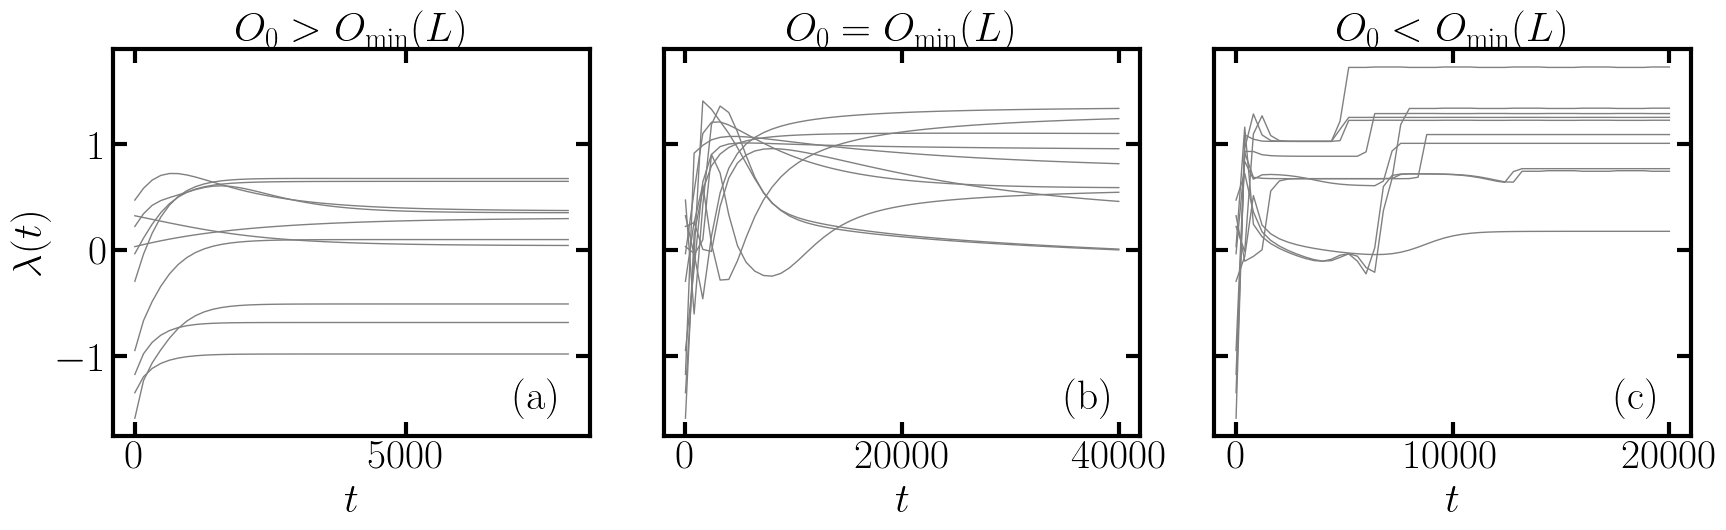

In [158]:
n = 6
L = 6

O0_list = [-0.2, 'c', -10]
eps_list = []
K_list = []
mu_list = []
for i in range(3):
    eps_list.append(np.load(f'data/training/RPA/Heisenberg/n{n}/finite/RPAepshistXXZ_n{n}L{L}Tgt{O0_list[i]}.npy'))
    K_list.append(np.load(f'data/training/RPA/Heisenberg/n{n}/finite/RPAKhistXXZ_n{n}L{L}Tgt{O0_list[i]}.npy'))
    mu_list.append(np.load(f'data/training/RPA/Heisenberg/n{n}/finite/RPAmuhistXXZ_n{n}L{L}Tgt{O0_list[i]}.npy'))

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
compare_ops = ['>', '=', '<']
for i in range(3):
    T = len(K_list[i])
    lda_hist = mu_list[i][:-1] / K_list[i][:T:T//50]
    zeta_hist = eps_list[i][:T:T//50] * mu_list[i][:-1] / K_list[i][:T:T//50]**2
    axs[i].plot(np.arange(0, T, T//50), lda_hist, c='grey', lw=1)
    axs[i].set_xlabel(r'$t$')
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on')
    axs[i].set_title(r'$O_0%s O_{\rm min}(L)$'%compare_ops[i], fontsize=30)
axs[0].set_ylabel(r'$\lambda(t)$')

axs[0].text(7000, -1.5, r'$\rm (a)$')
axs[1].text(35000, -1.5, r'$\rm (b)$')
axs[2].text(17500, -1.5, r'$\rm (c)$')

plt.tight_layout()

## restricted haar ensemble

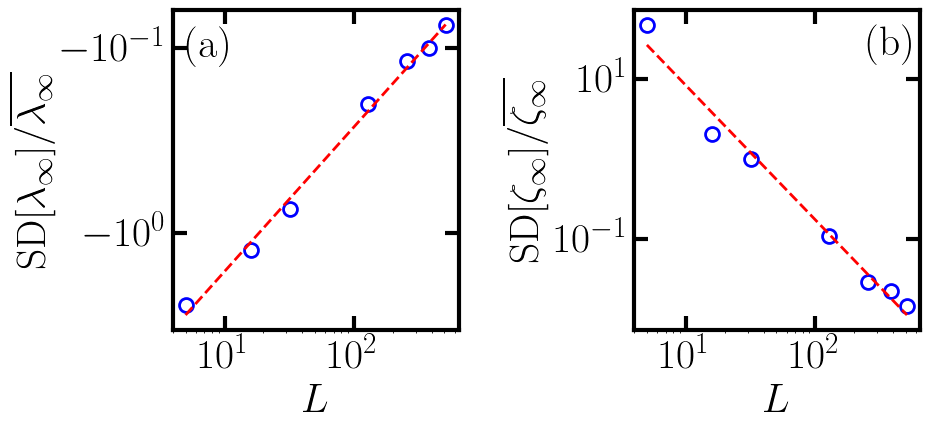

In [99]:
Ls1 = [5, 16, 32, 128, 256, 384, 512]
epss = np.zeros((len(Ls1), 100))
Ks = np.zeros((len(Ls1), 100))
mus = np.zeros((len(Ls1), 100))
for i in range(len(Ls1)):
    epss[i] = np.load(f'data/Training/RPA/randS/n5/RPAepshistrandS_n5L{Ls1[i]}Tgt1.0.npy')[-1]
    Ks[i] = np.load(f'data/Training/RPA/randS/n5/RPAKhistrandS_n5L{Ls1[i]}Tgt1.0.npy')[-1]
    mus[i] = np.load(f'data/Training/RPA/randS/n5/RPAmusrandS_n5L{Ls1[i]}Tgt1.0.npy')[1]
ldas = mus/Ks
zetas = epss*mus/Ks**2

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
lda_fluc = np.std(ldas, axis=1)/(np.mean(mus, axis=1)/np.mean(Ks, axis=1))
axs[0].plot(Ls1, -np.log10(-lda_fluc), 'o', mfc='white', markersize=10, markeredgewidth=2, c='b')
p0 = np.polyfit(x=np.log10(Ls1), y=np.log10(-lda_fluc), deg=1)
axs[0].plot(Ls1, -(p0[0]*np.log10(Ls1) + p0[1]), '--', lw=2, c='r')
axs[0].set_yticks([-np.log10(1), -np.log10(0.1)])
axs[0].set_yticklabels([r'$-10^0$', r'$-10^{-1}$'])

zeta_fluc = np.std(zetas, axis=1)/(np.mean(epss*mus, axis=1)/np.mean(Ks, axis=1)**2)
axs[1].plot(Ls1, zeta_fluc, 'o', mfc='white', markersize=10, markeredgewidth=2, c='b')
p1 = np.polyfit(x=np.log(Ls1), y=np.log(zeta_fluc), deg=1)
axs[1].plot(Ls1, np.exp(p1[1]) * Ls1**p1[0], '--', lw=2, c='r')
axs[1].set_yscale('log')

axs[0].set_ylabel(r'${\rm SD}[\lambda_\infty]/\overline{\lambda_\infty}$')
axs[1].set_ylabel(r'${\rm SD}[\zeta_\infty]/\overline{\zeta_\infty}$')
axs[0].set_xlabel(r'$L$')
axs[1].set_xlabel(r'$L$')
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on')
    axs[i].tick_params(axis='x', pad=8)

axs[0].text(x=5, y=0.95, s=r'$\rm (a)$')
axs[1].text(x=250, y=20, s=r'$\rm (b)$')

plt.tight_layout()

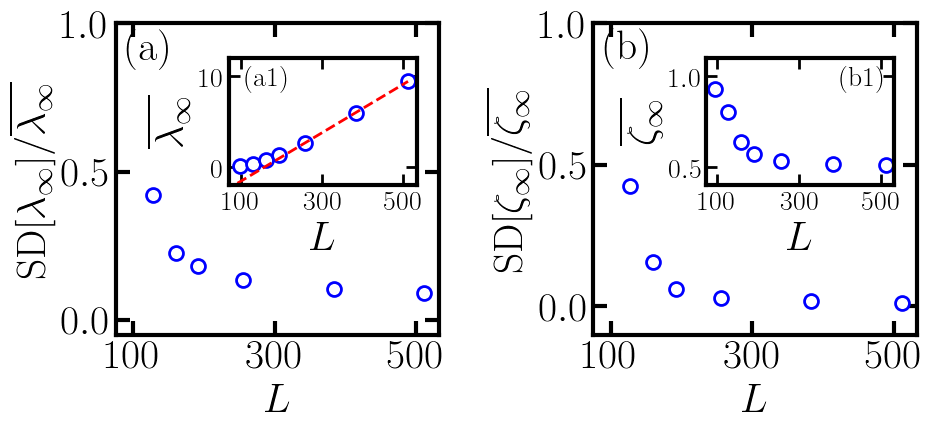

In [120]:
n = 6
Ls = [96, 128, 160, 192, 256, 384, 512]
O0 = -22

epss = np.zeros((len(Ls), 100))
Ks = np.zeros((len(Ls), 100))
mus = np.zeros((len(Ls), 100))

for i in range(len(Ls)):
    L = Ls[i]
    epss[i] = np.load(f'data/Training/RPA/Heisenberg/n{n}/lambda/RPAepshistXXZ_n{n}L{L}Tgt{O0}.npy')[-1]
    Ks[i] = np.load(f'data/Training/RPA/Heisenberg/n{n}/lambda/RPAKhistXXZ_n{n}L{L}Tgt{O0}.npy')[-1]
    mus[i] = np.load(f'data/Training/RPA/Heisenberg/n{n}/lambda/RPAmulateXXZ_n{n}L{L}Tgt{O0}.npy')
ldas = mus/Ks
zetas = epss*mus/Ks**2

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
axs[0].plot(Ls, np.std(ldas, axis=1)/(np.mean(mus, axis=1)/np.mean(Ks, axis=1)), 'o', mfc='white', markersize=10,
            markeredgewidth=2, c='b')
axs[1].plot(Ls, np.std(zetas, axis=1)/(np.mean(epss*mus, axis=1)/np.mean(Ks, axis=1)**2), 'o', mfc='white',
            markersize=10, markeredgewidth=2, c='b')
axs[0].set_xticks([100, 300, 500])
axs[0].set_ylim(-0.05, 1.0)
axs[1].set_ylim(-0.1, 1.0)
axs[0].set_ylabel(r'${\rm SD}[\lambda_\infty]/\overline{\lambda_\infty}$')
axs[1].set_ylabel(r'${\rm SD}[\zeta_\infty]/\overline{\zeta_\infty}$')
axs[0].set_xlabel(r'$L$')
axs[1].set_xlabel(r'$L$')

for i in range(2):
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on')

inset_ax0 = axs[0].inset_axes([0.35, 0.48, 0.58, 0.41])
inset_ax0.plot(Ls, np.mean(mus, axis=1)/np.mean(Ks, axis=1), 'o', mfc='white', markersize=10, 
               markeredgewidth=2, c='b')
p = np.polyfit(x=Ls1[4:], y=np.mean(mus[4:], axis=1)/np.mean(Ks[4:], axis=1), deg=1)
inset_ax0.plot(np.arange(90, 513), p[0]*np.arange(90, 513) + p[1], '--', c='r', lw=2)
inset_ax0.set_ylim(-2, 12)
inset_ax0.set_ylabel(r'$\overline{\lambda_\infty}$')
inset_ax0.set_xlabel(r'$L$')
inset_ax0.set_xticks([100, 300, 500])
inset_ax0.tick_params(direction='in', length=8, width=2, top='on', right='on', labelsize=20)

inset_ax1 = axs[1].inset_axes([0.35, 0.48, 0.58, 0.41])
inset_ax1.plot(Ls, np.mean(epss*mus, axis=1)/np.mean(Ks, axis=1)**2, 'o', mfc='white', markersize=10, 
               markeredgewidth=2, c='b')
inset_ax1.set_ylabel(r'$\overline{\zeta_\infty}$')
inset_ax1.set_xlabel(r'$L$')
inset_ax1.set_ylim(0.4, 1.1)
inset_ax1.set_xticks([100, 300, 500])
inset_ax1.tick_params(direction='in', length=8, width=2, top='on', right='on', labelsize=20)

axs[0].text(x=90, y=0.88, s=r'$\rm (a)$', fontsize=30)
axs[1].text(x=90, y=0.88, s=r'$\rm (b)$', fontsize=30)
inset_ax0.text(x=110, y=9, s=r'$\rm (a1)$', fontsize=20)
inset_ax1.text(x=400, y=0.95, s=r'$\rm (b1)$', fontsize=20)

plt.tight_layout()

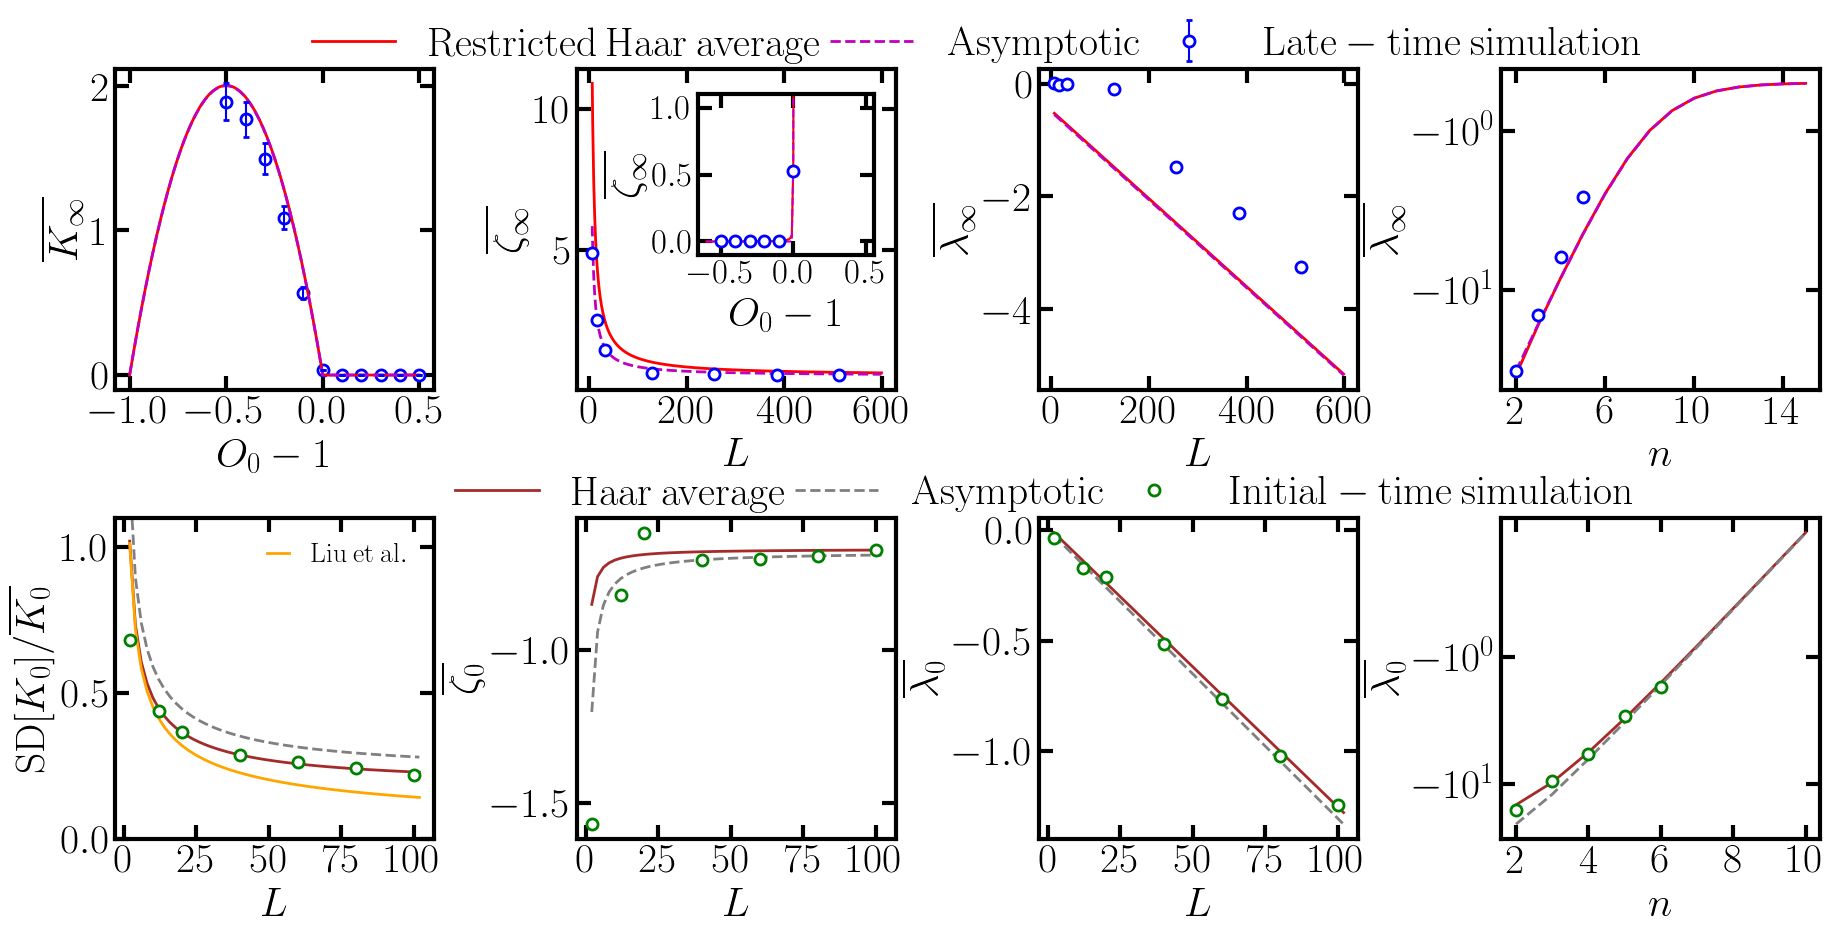

In [139]:
# restricted Haar result: state preparation
O0list = np.around(np.arange(0.5, 1.6, 0.1), 1)
Rlist = np.array([max(x-1, 0) for x in O0list])
Ks = np.zeros((len(O0list), 100))
zetas_O0 = np.zeros(len(O0list))
for i in range(len(O0list)):
    eps = np.load(f'data/Training/RPA/randS/n5/RPAepshistrandS_n5L512Tgt{O0list[i]}.npy')[-1]
    Ks[i] = np.load(f'data/Training/RPA/randS/n5/RPAKhistrandS_n5L512Tgt{O0list[i]}.npy')[-1]
    mu = np.load(f'data/Training/RPA/randS/n5/RPAmusrandS_n5L512Tgt{O0list[i]}.npy')[1]
    zetas_O0[i] = np.mean(eps*mu) / np.mean(Ks[i])**2

Ls1 = [5, 16, 32, 128, 256, 384, 512]
zetas_L = np.zeros(len(Ls1))
for i in range(len(Ls1)):
    eps = np.load(f'data/Training/RPA/randS/n5/RPAepshistrandS_n5L{Ls1[i]}Tgt1.0.npy')[-1]
    K = np.load(f'data/Training/RPA/randS/n5/RPAKhistrandS_n5L{Ls1[i]}Tgt1.0.npy')[-1]
    mu = np.load(f'data/Training/RPA/randS/n5/RPAmusrandS_n5L{Ls1[i]}Tgt1.0.npy')[1]
    zetas_L[i] = np.mean(eps*mu) / np.mean(K)**2

ldas_L = np.zeros(len(Ls1))
for i in range(len(Ls1)):
    K = np.load(f'data/Training/RPA/randS/n5/RPAKhistrandS_n5L{Ls1[i]}Tgt5.npy')[-1]
    mu = np.load(f'data/Training/RPA/randS/n5/RPAmuhistrandS_n5L{Ls1[i]}Tgt5.npy')[-1]
    ldas_L[i] = np.mean(mu) / np.mean(K)

ns1 = [2, 3, 4, 5]
ldas_n = np.zeros(4)
for i in range(4):
    n = ns1[i]
    K = np.load(f'data/Training/RPA/randS/n{n}/RPAKhistrandS_n{n}L512Tgt1.0.npy')[-1]
    mu = np.load(f'data/Training/RPA/randS/n{n}/RPAmusrandS_n{n}L512Tgt1.0.npy')[1]
    ldas_n[i] = np.mean(mu)/np.mean(K)

# Haar result: state preparation
Ls2 = np.array([2, 12] + list(range(20, 120, 20)))
Ks0_L = np.zeros((len(Ls2), 1000))
zetas0_L = np.zeros(len(Ls2))
ldas0_L = np.zeros(len(Ls2))
for i in range(len(Ls2)):
    L = Ls2[i]
    Ks0_L[i] = np.load(f'data/QNTK/RPA/n6/Heisenberg/RPAKXXZ_n6L{L}.npy')
    eps = np.load(f'data/QNTK/RPA/n6/Heisenberg/RPAepsXXZ_n6L{L}.npy')
    mu = np.load(f'data/QNTK/RPA/n6/Heisenberg/RPAmuXXZ_n6L{L}.npy')
    zetas0_L[i] = np.mean(eps*mu)/np.mean(Ks0_L[i])**2
    ldas0_L[i] = np.mean(mu)/np.mean(Ks0_L[i])

ns2 = [2, 3, 4, 5, 6]
ldas0_n = np.zeros(5)
for i in range(5):
    n = ns2[i]
    O0 = -6 - 4*i
    K = np.load(f'data/QNTK/RPA/Heisenberg/n{n}/RPAK0XXZ_n{n}L128Tgt{O0}.npy')
    mu = np.load(f'data/QNTK/RPA/Heisenberg/n{n}/RPAmu0XXZ_n{n}L128Tgt{O0}.npy')
    ldas0_n[i] = np.mean(mu)/np.mean(K)

ldas0_n_anal = np.zeros((2, 9))
for i in range(9):
    n = 2+i
    O = np.real(xxz(n, 2).full())
    ldas0_n_anal[0, i] = MumeanCor_RPA(n, 128, O)/KmeanTheory_RPA(n, 128, O)
    ldas0_n_anal[1, i] = 128 * np.trace(O @ O @ O) / (4*2**n * np.trace(O @ O))


fig, axs = plt.subplots(2, 4, figsize=(22, 10))

O0s = np.arange(0.0, 1.51, 0.01)
Rs = np.where(O0s<=1, 0, 1-O0s)

axs[0,0].plot(O0s-1, K_toy(5, 512, O0s, Rs), c='r', lw=2, label=r'$\rm Restricted\:Haar\:average$')
axs[0,0].plot(O0s-1, 512*(O0s+Rs)*(1-O0s-Rs)/(2*2**5), '--', c='m', lw=2, label=r'$\rm Asymptotic$')

axs[0,0].errorbar(np.array(O0list)-1, np.mean(Ks, axis=1), yerr=np.std(Ks, axis=1), fmt='o', barsabove=True,
                mfc='white', c='b', markersize=8, markeredgewidth=2, capsize=2, capthick=2,
                label=r'$\rm Late-time\:simulation$')

axs[0,0].set_xlabel(r'$O_0 - 1$')
axs[0,0].set_ylabel(r'$\overline{K_\infty}$')
axs[0,0].set_xticks([-1, -0.5, 0, 0.5])
axs[0,0].legend(ncol=3, columnspacing=0.2, loc='upper left', bbox_to_anchor=(0.5, 1.25), framealpha=0)

Lss1 = np.arange(6, 600)
axs[0,1].plot(Lss1, zeta_toy(6, Lss1, 1, -1e-3), lw=2, c='r')
axs[0,1].plot(Lss1, 1/2 + 2**5/Lss1, '--', lw=2, c='m')
axs[0,1].plot(Ls1, zetas_L, 'o', mfc='white', c='b', markersize=8, markeredgewidth=2)
axs[0,1].set_xlabel(r'$L$', fontsize=30)
axs[0,1].set_ylabel(r'$\overline{\zeta_\infty}$')
axs[0,1].set_xticks(np.arange(4)*200)

inset = axs[0,1].inset_axes([0.38, 0.42, 0.55, 0.5])
zeta_rh = [0]*60 + [1/2 + 2**5/512] + [(1/2 + 2**5/512) * (1-x-1e-3)/(-1e-3) for x in O0s[101:]]
inset.plot(O0s[40:]-1, zeta_toy(5, 512, O0s[40:], Rs[40:]-1e-3), c='r')
inset.plot(O0s[40:]-1, zeta_rh, '--', c='m')
inset.plot(O0list-1, zetas_O0, 'o', mfc='white', c='b', markersize=8, markeredgewidth=2)
inset.set_ylim(-0.1, 1.1)
inset.set_yticks([0, 0.5, 1])
inset.set_xlabel(r'$O_0 - 1$')
inset.set_ylabel(r'$\overline{\zeta_\infty}$', fontsize=30)
inset.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=25)

axs[0,2].plot(Lss1, lambda_toy(5, Lss1, 1, 0), lw=2, c='r')
axs[0,2].plot(Lss1, Lss1*(1-2)/(4*2**5) - 1/2, '--', lw=2, c='m')
axs[0,2].plot(Ls1, ldas_L, 'o', mfc='white', c='b', markersize=8, markeredgewidth=2)
axs[0,2].set_xlabel(r'$L$')
axs[0,2].set_ylabel(r'$\overline{\lambda_\infty}$')
axs[0,2].set_xticks(np.arange(4)*200)

nss = np.arange(2, 16)
axs[0,3].plot(nss, -np.log10(-lambda_toy(nss, 512, 0, 1)), lw=2, c='r')
axs[0,3].plot(nss, -np.log10(-(512*(1-2)/(4*2**nss) - 1/2)), '--', lw=2, c='m')
axs[0,3].plot(ns1, -np.log10(-ldas_n), 'o', mfc='white', c='b', markersize=8, markeredgewidth=2)
axs[0,3].set_xlabel(r'$n$')
axs[0,3].set_ylabel(r'$\overline{\lambda_\infty}$')
axs[0,3].set_xticks([2, 6, 10, 14])
axs[0,3].set_yticks([-np.log10(10), -np.log10(1)])
axs[0,3].set_yticklabels([r'$-10^1$', r'$-10^0$'])

Lss2 = np.arange(2, 104, 2)
O = np.real(xxz(6, 2).full())
axs[1,0].plot(Lss2, KstdTheoryCor_RPA(6, Lss2, O)/KmeanTheory_RPA(6, Lss2, O), lw=2, c='brown')
axs[1,0].plot(Lss2, KstdTheoryInd_RPA(6, Lss2, O)/KmeanTheory_RPA(6, Lss2, O), lw=2, c='orange', 
            label=r'$\rm Liu\: et\: al.$')
axs[1,0].plot(Lss2, np.sqrt(Lss2*np.trace(O @ O @ O @ O)/np.trace(O @ O)**2 + 3)/np.sqrt(Lss2), c='grey', 
            ls='--', lw=2)
axs[1,0].plot(Ls2, np.std(Ks0_L, axis=1)/np.mean(Ks0_L, axis=1), 'o', c='g', markersize=8, mfc='white', 
            markeredgewidth=2)
axs[1,0].legend(fontsize=20, framealpha=0, handlelength=0.8)
axs[1,0].set_xlabel(r'$L$')
axs[1,0].set_ylabel(r'${\rm SD}[K_0]/\overline{K_0}$')
axs[1,0].set_ylim(0, 1.1)
axs[1,0].set_xticks(np.arange(5)*25)

trO4 = np.trace(O @ O @ O @ O)
trO3 = np.trace(O @ O @ O)
trO2 = np.trace(O @ O)
axs[1,1].plot(Lss2, epsmuMeanCor_RPA(6, Lss2, O, -22)/KmeanTheory_RPA(6, Lss2, O)**2, lw=2, c='brown',
              label=r'$\rm Haar\:average$')
axs[1,1].plot(Lss2, -(1+trO4/trO2**2)/Lss2 + 0.5*(trO4/trO2**2 - 64*(-22)*trO3/trO2**2 - 3/64), '--', 
            lw=2, c='grey', label=r'$\rm Asymptotic$')
axs[1,1].plot(Ls2, zetas0_L, 'o', c='g', markersize=8, mfc='white', markeredgewidth=2, 
              label=r'$\rm Initial-time\:simulation$')
axs[1,1].set_xlabel(r'$L$')
axs[1,1].set_ylabel(r'$\overline{\zeta_0}$')
axs[1,1].set_xticks(np.arange(5)*25)
axs[1,1].legend(ncol=3, columnspacing=0.2, loc='upper left', bbox_to_anchor=(-0.5, 1.25), framealpha=0)

axs[1,2].plot(Lss2, MumeanCor_RPA(6, Lss2, O)/KmeanTheory_RPA(6, Lss2, O), lw=2, c='brown')
axs[1,2].plot(Lss2, Lss2*trO3/(4*2**6*trO2), '--', lw=2, c='grey')
axs[1,2].plot(Ls2, ldas0_L, 'o', c='g', markersize=8, mfc='white', markeredgewidth=2)
axs[1,2].set_xlabel(r'$L$')
axs[1,2].set_ylabel(r'$\overline{\lambda_0}$')
axs[1,2].set_xticks(np.arange(5)*25)

axs[1,3].plot(range(2, 11), -np.log10(-ldas0_n_anal[0]), lw=2, c='brown')
axs[1,3].plot(range(2, 11), -np.log10(-ldas0_n_anal[1]), '--', lw=2, c='grey')
axs[1,3].plot(ns2, -np.log10(-ldas0_n), 'o', c='g', markersize=8, mfc='white', markeredgewidth=2)
axs[1,3].set_xlabel(r'$n$')
axs[1,3].set_ylabel(r'$\overline{\lambda_0}$')
axs[1,3].set_xticks(np.arange(2, 12, 2))
axs[1,3].set_yticks([-np.log10(10), -np.log10(1)])
axs[1,3].set_yticklabels([r'$-10^1$', r'$-10^0$'])

for i in range(8):
    axs[i//4, i%4].tick_params(direction='in', length=10, width=3, top='on', right='on')

plt.subplots_adjust(wspace=0.45, hspace=0.4)

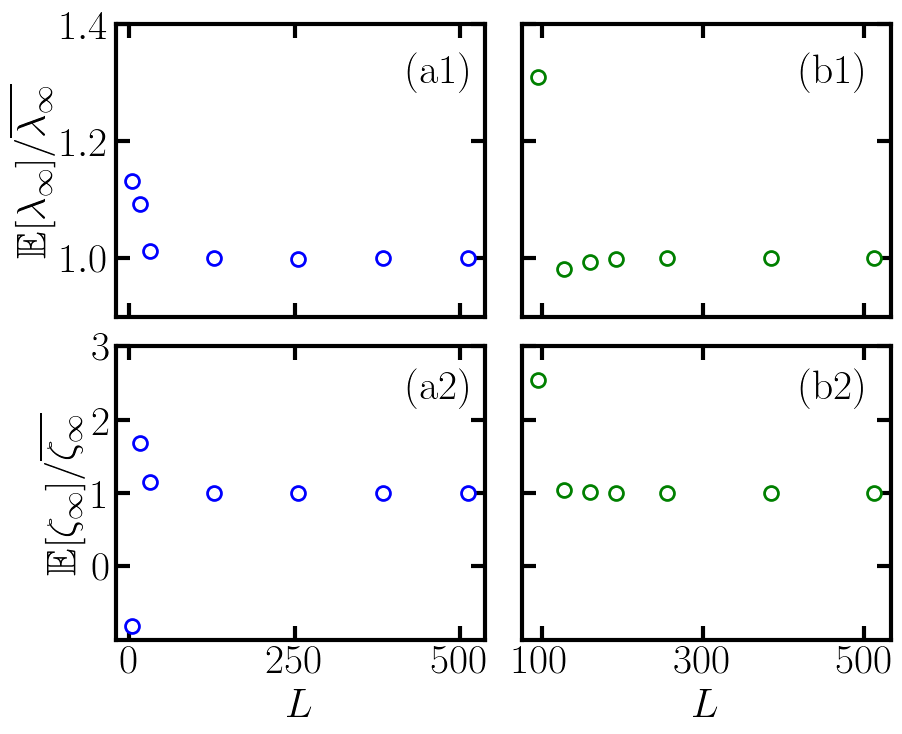

In [46]:
Ls1 = [5, 16, 32, 128, 256, 384, 512]
epss1 = np.zeros((len(Ls1), 100))
Ks1 = np.zeros((len(Ls1), 100))
mus1 = np.zeros((len(Ls1), 100))
for i in range(len(Ls1)):
    epss1[i] = np.load(f'data/Training/RPA/randS/n5/RPAepshistrandS_n5L{Ls1[i]}Tgt1.0.npy')[-1]
    Ks1[i] = np.load(f'data/Training/RPA/randS/n5/RPAKhistrandS_n5L{Ls1[i]}Tgt1.0.npy')[-1]
    mus1[i] = np.load(f'data/Training/RPA/randS/n5/RPAmusrandS_n5L{Ls1[i]}Tgt1.0.npy')[1]
ldas1 = mus1/Ks1
ldasbar1 = np.mean(mus1, axis=1)/np.mean(Ks1, axis=1)
zetas1 = epss1*mus1/Ks1**2
zetasbar1 = np.mean(epss1*mus1, axis=1)/np.mean(Ks1, axis=1)**2

Ls2 = [96, 128, 160, 192, 256, 384, 512]
epss2 = np.zeros((len(Ls2), 100))
Ks2 = np.zeros((len(Ls2), 100))
mus2 = np.zeros((len(Ls2), 100))
for i in range(len(Ls2)):
    epss2[i] = np.load(f'data/Training/RPA/Heisenberg/n6/lambda/RPAepshistXXZ_n6L{Ls2[i]}Tgt-22.npy')[-1]
    Ks2[i] = np.load(f'data/Training/RPA/Heisenberg/n6/lambda/RPAKhistXXZ_n6L{Ls2[i]}Tgt-22.npy')[-1]
    mus2[i] = np.load(f'data/Training/RPA/Heisenberg/n6/lambda/RPAmulateXXZ_n6L{Ls2[i]}Tgt-22.npy')
ldas2 = mus2/Ks2
ldasbar2 = np.mean(mus2, axis=1)/np.mean(Ks2, axis=1)
zetas2 = epss2*mus2/Ks2**2
zetasbar2 = np.mean(epss2*mus2, axis=1)/np.mean(Ks2, axis=1)**2

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(Ls1, np.mean(ldas1, axis=1)/ldasbar1, 'o', mfc='white', markersize=10, c='b',
               markeredgewidth=2)
axs[0, 1].plot(Ls2, np.mean(ldas2, axis=1)/ldasbar2, 'o', mfc='white', markersize=10, c='g',
               markeredgewidth=2)
axs[1, 0].plot(Ls1, np.mean(zetas1, axis=1)/zetasbar1, 'o', mfc='white', markersize=10, c='b',
               markeredgewidth=2)
axs[1, 1].plot(Ls2, np.mean(zetas2, axis=1)/zetasbar2, 'o', mfc='white', markersize=10, c='g',
               markeredgewidth=2)

axs[0, 0].set_ylabel(r'$\mathbb{E}[\lambda_\infty]/\overline{\lambda_\infty}$')
axs[1, 0].set_ylabel(r'$\mathbb{E}[\zeta_\infty]/\overline{\zeta_\infty}$')

for i in range(2):
    axs[0, i].set_ylim(0.9, 1.4)
    axs[1, i].set_ylim(-1, 3)
    axs[0, i].set_yticks([1.0, 1.2, 1.4])
    axs[1, i].set_yticks([0, 1, 2, 3])
    axs[i, 1].set_yticklabels([])
    axs[i, 0].set_xticks(np.arange(3)*250)
    axs[i, 1].set_xticks(np.arange(3)*200 + 100)
    axs[0, i].set_xticklabels([])
    axs[1, i].set_xlabel(r'$L$')

for i in range(4):
    axs[i//2, i%2].tick_params(direction='in', length=10, width=3, top='on', right='on')

axs[0,0].text(420, 1.3, s=r'$\rm (a1)$')
axs[1,0].text(420, 2.3, s=r'$\rm (a2)$')

axs[0,1].text(420, 1.3, s=r'$\rm (b1)$')
axs[1,1].text(420, 2.3, s=r'$\rm (b2)$')

plt.subplots_adjust(hspace=0.1, wspace=0.1)

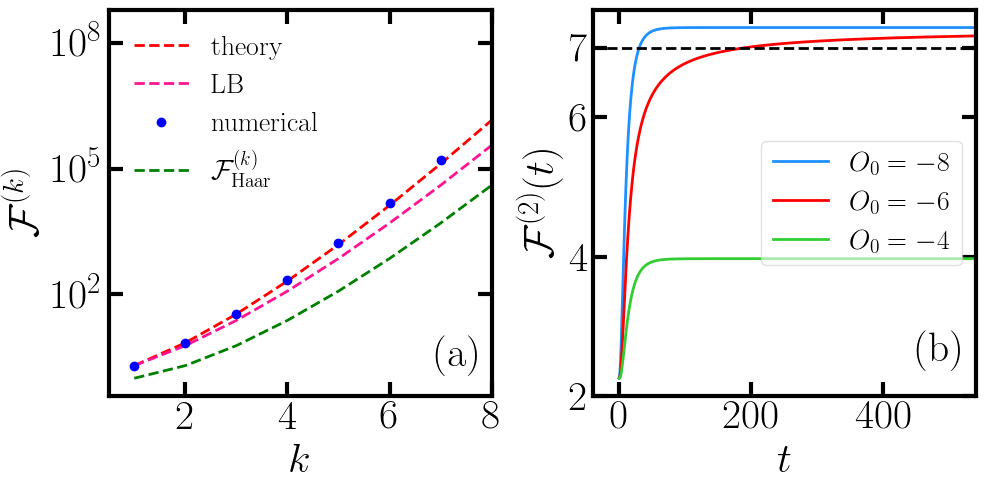

In [ ]:
Fs_theory = np.load('data/Training/qubits/RPA/randS/toyUFP_d4.npy')
Fs1 = np.load('data/Training/qubits/RPA/randS/toyUFP2_d4.npy')

O0_list = [-8., -6., -4.]
FP2_list = np.zeros((3, 1000))
for i in range(3):
    FP2_list[i] = np.load('data/training/qubits/RPA/Heisenberg/n2/RPAFP2HistXXZ_n2L64Tgt%s.npy'%O0_list[i])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(ks, Fs_theory, '--', lw=2, c='r', label=r'$\rm theory$')
axs[0].plot(ks, [(k+1)*factorial(k) for k in ks], '--', lw=2, c='deeppink', label=r'$\rm LB$')
axs[0].plot(range(1, 8), Fs1, 'o', markersize=6, c='b', label=r'$\rm numerical$')
axs[0].plot(ks, [factorial(k) for k in ks], '--', lw=2, c='g', label=r'$\mathcal{F}^{(k)}_{\rm Haar}$')
axs[0].legend(fontsize=20, framealpha=0)
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$k$', fontsize=30)
axs[0].set_ylabel(r'$\mathcal{F}^{(k)}$', fontsize=30)
axs[0].set_xticks(range(0, 10, 2))
axs[0].set_xlim(0.5, 8)
axs[0].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

cl = ['dodgerblue', 'r', 'limegreen']
for i in range(3):
    axs[1].plot(FP2_list[i], lw=2, c=cl[i], label=r'$O_0=%d$'%O0_list[i])
axs[1].plot(np.arange(-100, 1050), 7*np.ones(1150), lw=2, c='k', ls='--')
axs[1].legend(fontsize=20, framealpha=0.6, loc='center right')
axs[1].set_yticks([2, 4, 6, 7])
axs[1].set_xlim(-40, 540)
axs[1].set_ylabel(r'$\mathcal{F}^{(2)}(t)$', fontsize=30)
axs[1].set_xlabel(r'$t$', fontsize=30)
axs[1].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

axs[0].text(6.9, 2, r'$\rm (a)$', fontsize=30)
axs[1].text(450, 2.5, r'$\rm (b)$', fontsize=30)

plt.tight_layout()

## Linear loss

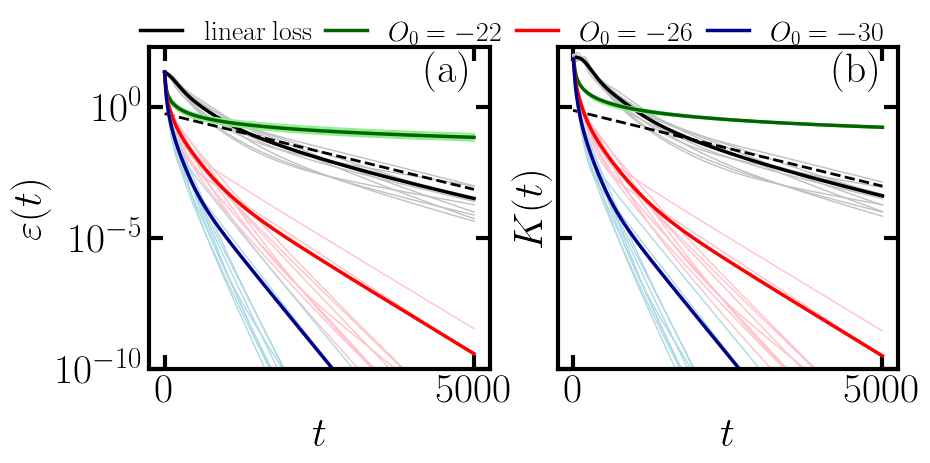

In [40]:
L = 192
Omin = -22
E_hist = np.load(f'data/linearLoss/Heisenberg/n6/RPAEhistXXZ_n6L{L}.npy')
Klinear_hist = np.load(f'data/linearLoss/Heisenberg/n6/RPAKhistXXZ_n6L{L}.npy')

O0s = [-22, -26, -30]
eps_hist = np.zeros((3, 5001, 10))
K_hist = np.zeros((3, 5001, 10))
for i in range(3):
    eps_hist[i] = np.load(f'data/linearLoss/Heisenberg/n6/RPAepshistXXZ_n6L{L}Tgt{O0s[i]}.npy')
    K_hist[i] = np.load(f'data/linearLoss/Heisenberg/n6/RPAKhistXXZ_n6L{L}Tgt{O0s[i]}.npy')

fig, axs = plt.subplots(1, 2, figsize=(10, 5.5), sharey=True, sharex=True)
cl = ['lightgreen', 'pink', 'lightblue']
cl2 = ['darkgreen', 'r', 'darkblue']
axs[0].plot(E_hist - Omin, lw=1, c='silver')
axs[0].plot(np.mean(E_hist, axis=1) - Omin, lw=2.5, c='k', label=r'$\rm linear\:loss$')
lda = 2/3
A = 1/(2*lda)
axs[0].plot(A*np.exp(-2*0.001*lda*ts)/(2*lda), '--', lw=2, c='k')
axs[1].plot(Klinear_hist, lw=1, c='silver')
axs[1].plot(np.mean(Klinear_hist, axis=1), lw=2.5, c='k')
axs[1].plot(A*np.exp(-2*0.001*lda*ts), '--', lw=2, c='k')
for i in range(3):
    axs[0].plot(eps_hist[i] + O0s[i] - O0s[0], lw=1, c=cl[i])
    axs[0].plot(np.mean(eps_hist[i], axis=1) + O0s[i] - O0s[0], lw=2.5, c=cl2[i], 
                label=fr'$O_0 = {O0s[i]}$')
    axs[1].plot(K_hist[i], lw=1, c=cl[i])
    axs[1].plot(np.mean(K_hist[i], axis=1), lw=2.5, c=cl2[i])
axs[0].legend(fontsize=20, ncols=4, columnspacing=0.5, loc='upper left', bbox_to_anchor=(-0.1, 1.16), 
              framealpha=0, handlelength=1.5)
axs[0].set_ylim(1e-10, 200)
axs[0].set_ylabel(r'$\varepsilon(t)$')
axs[1].set_ylabel(r'$K(t)$')
for i in range(2):
    axs[i].set_yscale('log')
    axs[i].set_xlabel(r'$t$')
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on')

axs[0].text(4200, 10, r'$\rm (a)$')
axs[1].text(4200, 10, r'$\rm (b)$')

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('figures/summary/revision/linearloss.pdf', bbox_inches='tight')
plt.show()
plt.close()

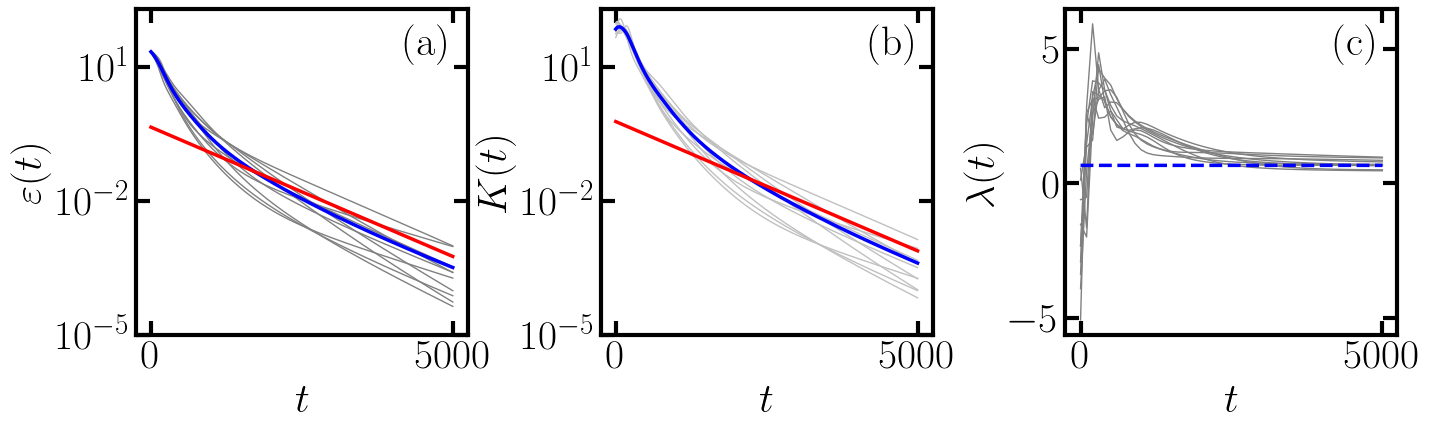

In [126]:
L = 192
Omin = -22
E_hist = np.load(f'data/linearLoss/Heisenberg/n6/RPAEhistXXZ_n6L{L}.npy')
K_hist = np.load(f'data/linearLoss/Heisenberg/n6/RPAKhistXXZ_n6L{L}.npy')
mu_hist = np.load(f'data/linearLoss/Heisenberg/n6/RPAmuhistXXZ_n6L{L}.npy')

lda = np.mean(mu_hist[-1])/np.mean(K_hist[-1])


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
ts = np.arange(len(K_hist))
A = 0.6
axs[0].plot(E_hist - Omin, lw=1, c='grey')
axs[0].plot(np.mean(E_hist, axis=1) - Omin, lw=2.5, c='b')
axs[0].plot(A*np.exp(-2*0.001*lda*ts)/(2*lda), lw=2.5, c='r')

axs[1].plot(K_hist, lw=1, c='silver')
axs[1].plot(np.mean(K_hist, axis=1), lw=2.5, c='b')
axs[1].plot(A*np.exp(-2*0.001*lda*ts), lw=2.5, c='r')

axs[2].plot(np.arange(0, 5001, 100), mu_hist[:-1]/K_hist[::100], lw=1, c='grey')
axs[2].plot(np.mean(mu_hist[-1])/np.mean(K_hist[-1])*np.ones_like(ts), '--', lw=2.5, c='b')

axs[0].set_ylabel(r'$\varepsilon(t)$')
axs[1].set_ylabel(r'$K(t)$')
axs[2].set_ylabel(r'$\lambda(t)$')
for i in range(2):
    axs[i].set_yscale('log')
    axs[i].set_ylim(1e-5, 200)
    
for i in range(3):
    axs[i].set_xlabel(r'$t$')
    axs[i].tick_params(direction='in', length=10, width=3, top='on', right='on')

axs[0].text(4200, 20, r'$\rm (a)$')
axs[1].text(4200, 20, r'$\rm (b)$')
axs[2].text(4200, 4.8, r'$\rm (c)$')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

## Schrodinger eq interpretation

[ 0.98753629 -3.62002586] [ 1.13037455 -2.68528719]
[ 0.99694037 -3.36233302] [ 1.09000183 -2.3478888 ]
[ 0.99825555 -3.16469578] [ 1.09747375 -2.27761499]
[ 0.99709841 -2.98919119] [ 1.09081085 -2.20780122]
[ 0.99931544 -2.90352363] [ 1.06443491 -2.10395809]


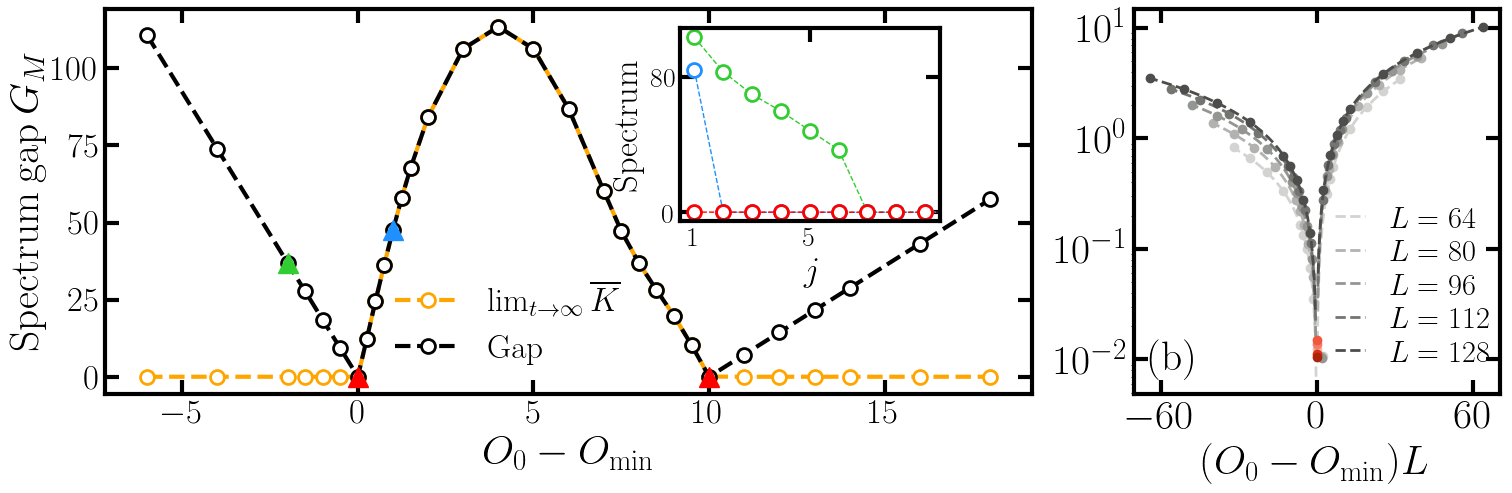

In [4]:
fig = plt.figure(figsize=(18, 5))
gs = GridSpec(1, 30, figure=fig)
ax0 = plt.subplot(gs[:, :20])
ax1 = plt.subplot(gs[:, 22:]) 

O0_list = np.array([-12, -10] + [-8+0.5*x for x in range(4)] + [-6+0.25*x for x in range(7)]
                    + [-4+x for x in range(5)] + [1+0.5*x for x in range(7)]
                    + [5, 6, 7, 8, 10, 12])

vals_list = []
gap = np.zeros(len(O0_list))
K_list = np.zeros(len(O0_list))
for i, O0 in enumerate(O0_list):
    hs = np.load('data/Training/RPA/Heisenberg/n2/hess/RPAhessHistXXZ_n2L64Tgt%s.npy'%O0)[-1]
    vals = np.mean(np.linalg.eigvalsh(hs), axis=0)
    if O0 in [-8., -6., -4.]:
        vals_list.append(vals)
    gap[i] = vals[np.where(np.around(vals, 3) > 0)[0][0]]
    Ks = np.load('data/Training/RPA/Heisenberg/n2/hess/RPAKHistXXZ_n2L64Tgt%s.npy'%O0)[-1]
    K_list[i] = np.mean(Ks)

tau = O0_list + 6
ax0.plot(tau, K_list, 'o--', c='orange', mfc='white', markersize=10, markeredgewidth=2, lw=3, 
         label=r'$\lim_{t\to \infty}\overline{K}$')
ax0.plot(tau, gap, 'o--', c='k', mfc='white', markersize=10, markeredgewidth=2, lw=3, 
         label=r'$\rm Gap$')
ax0.legend(loc='lower left', bbox_to_anchor=(0.28, 0.), fontsize=24, framealpha=0)
ax0.plot(tau[2], gap[2], '^', markersize=15, c='limegreen')
ax0.plot(tau[6], gap[6], '^', markersize=15, c='r')
ax0.plot(tau[10], gap[10], '^', markersize=15, c='dodgerblue')
ax0.plot(tau[24], gap[24], '^', markersize=15, c='r')
ax0.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=25)
ax0.set_ylabel(r'${\rm Spectrum\:gap}\: G_M$')
ax0.set_xlabel(r'$O_0 - O_{\rm min}$')

L = 64
inset_ax = ax0.inset_axes([0.62, 0.45, 0.28, 0.5])
inset_ax.plot(np.arange(1, L+1), vals_list[0][::-1], 'o--', markersize=10, markeredgewidth=2, lw=1, 
              mfc='white', c='limegreen')
inset_ax.plot(np.arange(1, L+1), vals_list[2][::-1], 'o--', markersize=10, markeredgewidth=2, lw=1, 
              mfc='white', c='dodgerblue')
inset_ax.plot(np.arange(1, L+1), vals_list[1][::-1], 'o--', markersize=10, lw=1, markeredgewidth=2, 
              mfc='white', c='r')
inset_ax.set_xlim(0.5, 9.5)
inset_ax.set_xlabel(r'$j$', fontsize=25)
inset_ax.set_ylabel(r'$\rm Spectrum$', fontsize=25)
inset_ax.set_xticks([1, 5])
inset_ax.set_yticks([0, 80])
inset_ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=20)

n = 4
Ls = [64, 80, 96, 112, 128]
O0s = [-14.5+0.1*x for x in range(4)] + [round(-14.1+0.02*x, 2) for x in range(5)]\
    + [-14] + [round(-13.98+0.02*x, 2) for x in range(5)]\
    + [round(-13.8+0.1*x, 1) for x in range(4)]
gaps = np.load(f'data/Training/RPA/Heisenberg/n{n}/RPAgapsXXZ_n{n}.npy')
Ks = np.load(f'data/Training/RPA/Heisenberg/n{n}/RPAKsXXZ_n{n}.npy')

cl = ['#F9B8AD', '#F47C68', '#F1573D', '#E22E10', '#AC230C']
cl2 = ['#D3D4D2', '#B2B3B1', '#949692', '#737571', '#4D4E4C']
O0s_plot = np.array(O0s)
O0ss = np.arange(0.004, 0.501, 0.001)
for i in range(len(Ls)):
    g_gap = (gaps[i, 1:] - gaps[i, :-1])/(O0s_plot[1:] - O0s_plot[:-1])
    g_k = (Ks[i, 1:] - Ks[i, :-1])/(O0s_plot[1:] - O0s_plot[:-1])
    #ax1.plot((O0s_plot + 14)*Ls[i], gaps[i], 'o', c=cl[i], label=fr'$L={Ls[i]}$')
    p1 = np.polyfit(x=np.log(np.abs(O0s_plot[:9] + 14)*Ls[i]), y=np.log(gaps[i, :9]), deg=1)
    p2 = np.polyfit(x=np.log(np.abs(O0s_plot[12:] + 14)*Ls[i]), y=np.log(gaps[i, 12:]), deg=1)
    ax1.plot((O0s_plot[10:] + 14)*Ls[i], gaps[i, 10:], 'o', c=cl2[i], markersize=6)
    ax1.plot(O0ss*Ls[i], np.exp(p2[1])*(O0ss*Ls[i])**p2[0], '--', lw=2, c=cl2[i], label=fr'$L={Ls[i]}$')
    ax1.plot((O0s_plot[:9] + 14)*Ls[i], gaps[i, :9], 'o', c=cl2[i], markersize=6)
    ax1.plot(-O0ss *Ls[i], np.exp(p1[1])*(O0ss*Ls[i])**p1[0], '--', lw=2, c=cl2[i])
    ax1.plot(0, gaps[i, 9], 'o', c=cl[i], markersize=6)
    print(p1, p2)
ax1.legend(fontsize=22, handlelength=1, framealpha=0, labelspacing=0.2, loc='lower right', bbox_to_anchor=(1.05, 0.))
ax1.set_yscale('log')
ax1.set_xlabel(r'$(O_0 - O_{\rm min})L$')
ax1.set_xticks([-60, 0, 60])
ax1.tick_params(direction='in', length=10, width=3, top='on', right='on')

#fig.text(0.135, 0.16, r'$\rm (a)$')
#fig.text(0.55, 0.75, r'$\rm (a1)$')
fig.text(0.705, 0.16, r'$\rm (b)$')

In [255]:
p1s = [0.98753629, 0.99694037, 0.99825555, 0.99709841, 0.99931544]
p2s = [1.13037455, 1.09000183, 1.09747375, 1.09081085, 1.06443491]
np.mean(p1s), np.std(p1s), np.mean(p2s), np.std(p2s)

(0.995829212, 0.004234595440428298, 1.094619178, 0.021135318817401758)

In [329]:
p1s = [-0.94160349, -0.97356091, -0.96952947, -0.95200782, -0.96627019]
p2s = [-1.02936525, -0.99823115, -0.99048476, -0.97610248, -1.04507756]
np.mean(p1s), np.std(p1s), np.mean(p2s), np.std(p2s)

(-0.9605943760000001,
 0.011954618089514375,
 -1.0078522399999998,
 0.02549814127640913)

[-0.94160349  9.82975607] [-1.02936525  9.79824938]
[-0.97356091  9.58976883] [-0.99823115  9.39642708]
[-0.96952947  9.32383839] [-0.99048476  9.21545865]
[-0.95200782  9.15548866] [-0.97610248  9.13321146]
[-0.96627019  9.15712807] [-1.04507756  9.19292034]


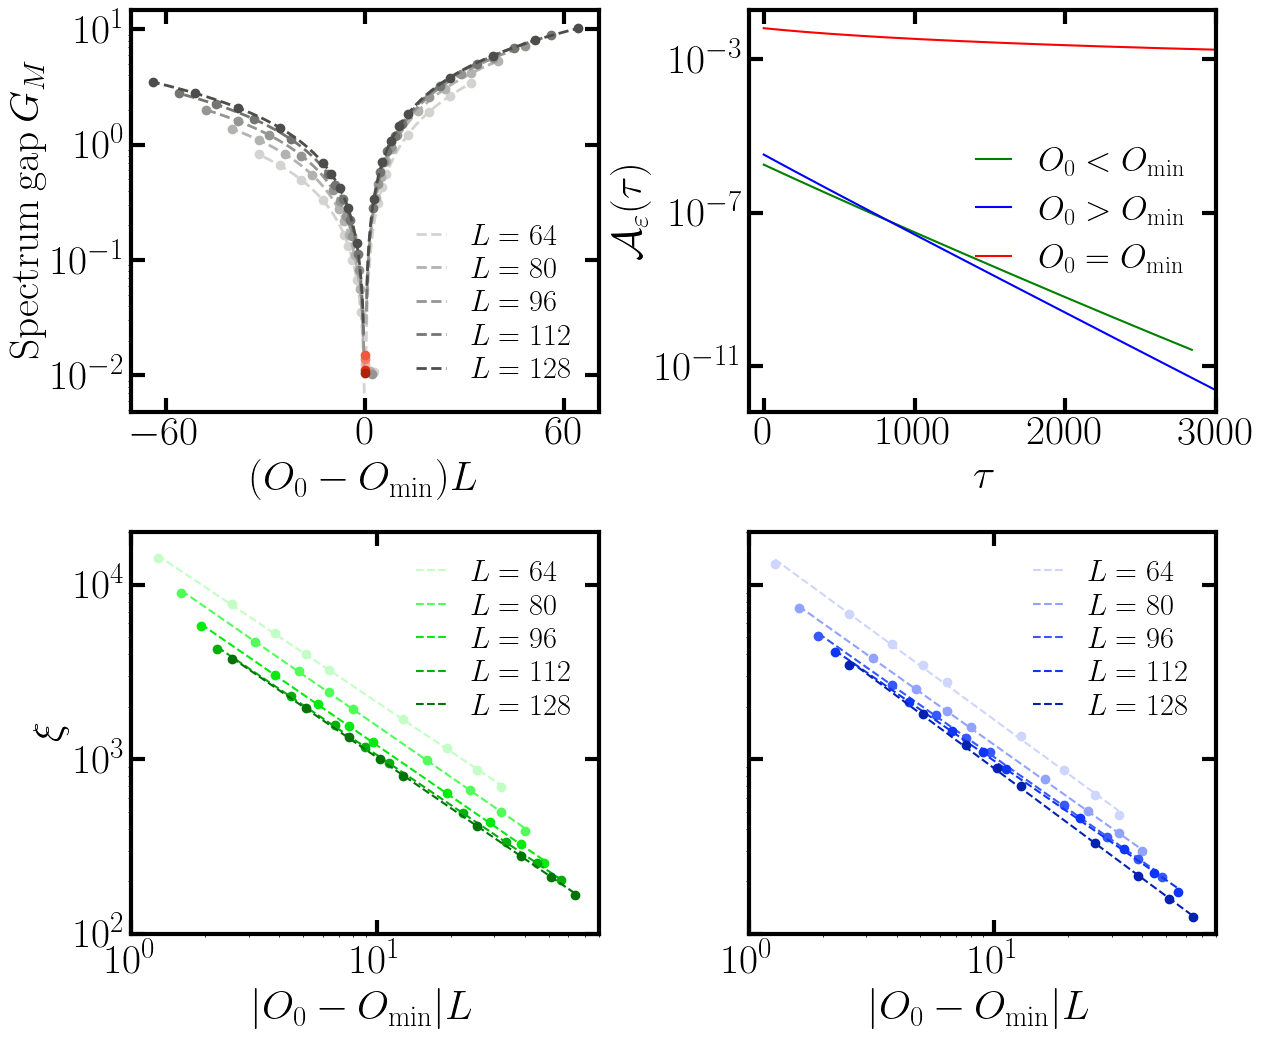

: 

In [4]:
n = 4
Ls = [64, 80, 96, 112, 128]
O0s = [-14.5+0.1*x for x in range(4)] + [round(-14.1+0.02*x, 2) for x in range(5)]\
    + [-14] + [round(-13.98+0.02*x, 2) for x in range(5)]\
    + [round(-13.8+0.1*x, 1) for x in range(4)]

xis = np.zeros((len(Ls), len(O0s)))
for i, L in enumerate(Ls):
    for j, O0 in enumerate(O0s):
        eps_hist = np.load(f'data/Training/RPA/Heisenberg/n{n}/L{L}/RPAepshistXXZ_n{n}L{L}_{O0}.npy')
        if O0 > -14.:
            veps = eps_hist
        else:
            veps = eps_hist + O0 + 14
        veps_mean = np.mean(veps, axis=1)

        if O0 != -14:
            t_begin = np.argmin(np.abs(veps_mean - 1e-3))
            A = np.mean(veps[t_begin] * veps[t_begin:], axis=1)
            p = np.polyfit(x=np.log(A), y=-np.arange(len(A)), deg=1)
            xis[i, j] = p[0]
            if O0 == -14.5 and L == 96:
                As1 = A
            elif O0 == -13.5 and L == 96:
                As2 = A
        else:
            A = np.mean(veps[1000] * veps[1000:], axis=1)
            if L == 96:
                Asc = A

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

n = 4
Ls = [64, 80, 96, 112, 128]
O0s = [-14.5+0.1*x for x in range(4)] + [round(-14.1+0.02*x, 2) for x in range(5)]\
    + [-14] + [round(-13.98+0.02*x, 2) for x in range(5)]\
    + [round(-13.8+0.1*x, 1) for x in range(4)]
gaps = np.load(f'data/Training/RPA/Heisenberg/n{n}/RPAgapsXXZ_n{n}.npy')
Ks = np.load(f'data/Training/RPA/Heisenberg/n{n}/RPAKsXXZ_n{n}.npy')

cl = ['#F9B8AD', '#F47C68', '#F1573D', '#E22E10', '#AC230C']
cl2 = ['#D3D4D2', '#B2B3B1', '#949692', '#737571', '#4D4E4C']
O0s_plot = np.array(O0s)
O0ss = np.arange(0.004, 0.501, 0.001)
for i in range(len(Ls)):
    g_gap = (gaps[i, 1:] - gaps[i, :-1])/(O0s_plot[1:] - O0s_plot[:-1])
    g_k = (Ks[i, 1:] - Ks[i, :-1])/(O0s_plot[1:] - O0s_plot[:-1])
    #ax1.plot((O0s_plot + 14)*Ls[i], gaps[i], 'o', c=cl[i], label=fr'$L={Ls[i]}$')
    p1 = np.polyfit(x=np.log(np.abs(O0s_plot[:9] + 14)*Ls[i]), y=np.log(gaps[i, :9]), deg=1)
    p2 = np.polyfit(x=np.log(np.abs(O0s_plot[12:] + 14)*Ls[i]), y=np.log(gaps[i, 12:]), deg=1)
    axs[0, 0].plot((O0s_plot[10:] + 14)*Ls[i], gaps[i, 10:], 'o', c=cl2[i], markersize=6)
    axs[0, 0].plot(O0ss*Ls[i], np.exp(p2[1])*(O0ss*Ls[i])**p2[0], '--', lw=2, c=cl2[i], label=fr'$L={Ls[i]}$')
    axs[0, 0].plot((O0s_plot[:9] + 14)*Ls[i], gaps[i, :9], 'o', c=cl2[i], markersize=6)
    axs[0, 0].plot(-O0ss *Ls[i], np.exp(p1[1])*(O0ss*Ls[i])**p1[0], '--', lw=2, c=cl2[i])
    axs[0, 0].plot(0, gaps[i, 9], 'o', c=cl[i], markersize=6)

axs[0, 0].legend(fontsize=22, handlelength=1, framealpha=0, labelspacing=0.2, loc='lower right', 
                 bbox_to_anchor=(1, 0.))
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel(r'$(O_0 - O_{\rm min})L$')
axs[0, 0].set_ylabel(r'${\rm Spectrum\:gap}\: G_M$')
axs[0, 0].set_xticks([-60, 0, 60])
axs[0, 0].tick_params(direction='in', length=10, width=3, top='on', right='on')


cl1 = ['#CED6FE', '#91A3FD', '#3758FB', '#0E35FA', '#0421B0']
cl2 = ['#C2FEC5', '#51FD59', '#03EB0E', '#02AE0A', '#027407']

axs[0, 1].plot(As1, c='g', label=r'$O_0 < O_{\rm min}$')
axs[0, 1].plot(As2, c='b', label=r'$O_0 > O_{\rm min}$')
axs[0, 1].plot(Asc, c='r', label=r'$O_0 = O_{\rm min}$')
axs[0, 1].legend(fontsize=25, handlelength=1, framealpha=0)
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlim(-100, 3000)
axs[0, 1].set_ylabel(r'$\mathcal{A}_{\varepsilon}(\tau)$')
axs[0, 1].set_xlabel(r'$\tau$')
axs[0, 1].set_xticks([0, 1000, 2000, 3000])
axs[0, 1].set_yticks([1e-11, 1e-7, 1e-3])
axs[0, 1].tick_params(direction='in', length=10, width=3, top='on', right='on')

O0s_plot = np.array(O0s)
O0ss = np.arange(0.02, 0.501, 0.001)
for i in range(5):  
    axs[1, 0].plot(np.abs(O0s_plot[:9] + 14)*Ls[i], xis[i, :9], 'o', c=cl2[i])
    p1 = np.polyfit(x=np.log(np.abs(O0s_plot[:9] + 14)*Ls[i]), y=np.log(xis[i, :9]), deg=1)
    axs[1, 0].plot(O0ss*Ls[i], np.exp(p1[1])*(O0ss*Ls[i])**p1[0], '--', c=cl2[i], label=fr'$L={Ls[i]}$')
    axs[1, 1].plot(np.abs(O0s_plot[10:] + 14)*Ls[i], xis[i, 10:], 'o', c=cl1[i])
    p2 = np.polyfit(x=np.log(np.abs(O0s_plot[10:] + 14)*Ls[i]), y=np.log(xis[i, 10:]), deg=1)
    axs[1, 1].plot(O0ss*Ls[i], np.exp(p2[1])*(O0ss*Ls[i])**p2[0], '--', c=cl1[i], label=fr'$L={Ls[i]}$')
    print(p1, p2)

axs[1, 0].set_yscale('log')
axs[1, 0].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xscale('log')
axs[1, 0].set_xlabel(r'$|O_0 - O_{\rm min}|L$')
axs[1, 1].set_xlabel(r'$|O_0 - O_{\rm min}|L$')
axs[1, 0].set_ylabel(r'$\xi$')
axs[1, 0].set_yticks([1e2, 1e3, 1e4])
axs[1, 0].set_xticks([1, 10])
axs[1, 0].set_ylim(1e2, 2e4)
axs[1, 0].set_xlim(1, 80)
axs[1, 1].set_yticks([1e2, 1e3, 1e4])
axs[1, 1].set_ylim(1e2, 2e4)
axs[1, 1].set_yticklabels([])
axs[1, 1].set_xlim(1, 80)
axs[1, 0].legend(fontsize=22, handlelength=1, framealpha=0, labelspacing=0.2, loc='upper right')
axs[1, 1].legend(fontsize=22, handlelength=1, framealpha=0, labelspacing=0.2, loc='upper right')
axs[1, 0].tick_params(direction='in', length=10, width=3, top='on', right='on')
axs[1, 0].tick_params(axis='x', pad=8)
axs[1, 1].tick_params(direction='in', length=10, width=3, top='on', right='on')
axs[1, 1].tick_params(axis='x', pad=8)

plt.subplots_adjust(hspace=0.3, wspace=0.32)

In [ ]:
O0_list = np.array([-8.] + [round(-6.- 10.**x,2) for x in np.arange(0.2, -1.1, -0.1)]
            + [round(-6. + 10.**x,2) for x in np.arange(-1., 0.3, 0.1)] + [-4.])

R_list = [min(x+6, 0) for x in O0_list]

Aeps = []
AK = []
xi_list = np.zeros((2, len(O0_list)))
for i in range(len(O0_list)):
    eps = np.load('data/training/qubits/RPA/Heisenberg/n2/correlation_length/RPAepsHistXXZ_n2L64Tgt%s.npy'%O0_list[i])
    vareps_mean = np.mean(eps + R_list[i], axis=1)
    t_begin = np.argmin(np.abs(vareps_mean - 1e-8))
    t_end = np.argmin(np.abs(vareps_mean - 1e-11)) + 1
    t_end1 = np.argmin(np.abs(vareps_mean - 5e-12))
    t_end2 = np.argmin(np.abs(vareps_mean - 1e-12))+1

    A = np.mean((eps[t_begin] + R_list[i]) * (eps[t_begin:t_end] + R_list[i]), axis=1)
    Aeps.append(A)
    p = np.polyfit(x=np.log(A), y=-np.arange(len(A)), deg=1)
    xi_list[0, i] = p[0]

    K = np.load('data/training/qubits/RPA/Heisenberg/n2/correlation_length/RPAKHistXXZ_n2L64Tgt%s.npy'%O0_list[i])
    #A = np.mean((K[t_begin] * K[t_begin:t_end], axis=1) - np.mean(K[t_begin]) * np.mean(K[t_end])
    K_inf = np.sum(K[t_end1:t_end2], axis=0)/(t_end2 - t_end1)
    A = np.mean((K[t_begin] - K_inf) * (K[t_begin:t_end] - K_inf), axis=1)
    AK.append(A)
    p = np.polyfit(x=np.log(A), y=-np.arange(len(A)), deg=1)
    xi_list[1, i] = p[0]

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
for i in range(14):
    axs[0, 0].plot(Aeps[i], c='limegreen')
for i in range(14):
    axs[0, 1].plot(AK[i], c='limegreen')
axs[0, 0].set_yscale('log')
axs[0, 1].set_yscale('log')
axs[0, 0].set_ylim(4e-18, 2e-14)
axs[0, 0].set_xlim(-20, 2000)
axs[0, 1].set_ylim(6e-15, 1e-11)
axs[0, 1].set_xlim(-20, 2000)
axs[0, 0].set_ylabel(r'$\mathcal{A}_\epsilon(\tau)$', fontsize=30)
axs[0, 1].set_ylabel(r'$\mathcal{A}_K(\tau)$', fontsize=30)

axs[0, 2].plot(np.abs(R_list[:14]), xi_list[0, :14], 'o', markersize=10, c='mediumseagreen', 
               label=r'$\xi_\epsilon$')
axs[0, 2].plot(np.abs(R_list[:14]), xi_list[1, :14], 'o', markersize=10, c='hotpink', 
               label=r'$\xi_K$')
p1 = np.polyfit(x=np.log(np.abs(R_list[:14])), y=np.log(xi_list[0, :14]), deg=1)
p2 = np.polyfit(x=np.log(np.abs(R_list[:14])), y=np.log(xi_list[1, :14]), deg=1)
print('<: eps:%s, K:%s'%(p1[0], p2[0]))
axs[0, 2].plot(np.abs(R_list[:14]), np.exp(p1[1])*np.abs(R_list[:14])**p1[0], '--', 
               lw=2, c='darkseagreen')
axs[0, 2].plot(np.abs(R_list[:14]), np.exp(p1[1])*np.abs(R_list[:14])**p1[0], '--', 
               lw=2, c='darkviolet')
axs[0, 2].plot(np.abs(R_list[:14]), 0.05/(0.001*np.abs(R_list[:14])), '--', c='k', lw=2, 
               label=r'$\frac{1}{|O_0 - O_{\rm min}|}$')
axs[0, 2].legend(fontsize=20, framealpha=0, handlelength=1)
axs[0, 2].set_xscale('log')
axs[0, 2].set_yscale('log')
axs[0, 2].set_ylabel(r'$\xi$', fontsize=30)

for i in range(14, 28):
    axs[1, 0].plot(Aeps[i], c='dodgerblue')
for i in range(14, 28):
    axs[1, 1].plot(AK[i], c='dodgerblue')
axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
axs[1, 0].set_ylim(4e-17, 2e-14)
axs[1, 0].set_xlim(-20, 2000)
axs[1, 1].set_ylim(6e-15, 1e-11)
axs[1, 1].set_xlim(-20, 2000)
axs[1, 0].set_ylabel(r'$\mathcal{A}_\epsilon(\tau)$', fontsize=30)
axs[1, 1].set_ylabel(r'$\mathcal{A}_K(\tau)$', fontsize=30)

axs[1, 2].plot(np.abs(O0_list[14:] + 6), xi_list[0, 14:], 'o', markersize=8, c='mediumseagreen',
               label=r'$\xi_\epsilon$')
axs[1, 2].plot(np.abs(O0_list[14:] + 6), xi_list[1, 14:], 'o', markersize=8, c='hotpink',
               label=r'$\xi_K$')
p1 = np.polyfit(x=np.log(np.abs(O0_list[14:25] + 6)), y=np.log(xi_list[0, 14:25]), deg=1)
p2 = np.polyfit(x=np.log(np.abs(O0_list[14:25] + 6)), y=np.log(xi_list[1, 14:25]), deg=1)
print('>: eps:%s, K:%s'%(p1[0], p2[0]))
axs[1, 2].plot(np.abs(O0_list[14:] + 6), np.exp(p1[1])*np.abs(O0_list[14:] + 6)**p1[0], '--', 
               lw=2, c='darkseagreen')
axs[1, 2].plot(np.abs(O0_list[14:] + 6), np.exp(p1[1])*np.abs(O0_list[14:] + 6)**p1[0], '--', 
               lw=2, c='darkviolet')
axs[1, 2].plot(np.abs(O0_list[14:] + 6), 0.05/(0.001*np.abs(O0_list[14:] + 6)), '--', lw=2, c='k', 
               label=r'$\frac{1}{|O_0 - O_{\rm min}|}$')
axs[1, 2].legend(fontsize=20, framealpha=0, handlelength=1)
axs[1, 2].set_xscale('log')
axs[1, 2].set_yscale('log')
axs[1, 2].set_ylabel(r'$\xi$', fontsize=30)
axs[1, 2].set_xlabel(r'$|O_0 - O_{\rm min}|$', fontsize=30)

for i in range(3):
    if (2-i):
        axs[1, i].set_xlabel(r'$\tau$', fontsize=30)
    axs[0, i].set_xticklabels([])
for i in range(6):
    axs[i//3, i%3].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=25)

axs[0, 0].text(1700, 9e-15, r'$\rm (a)$', fontsize=30)
axs[1, 0].text(1700, 1e-14, r'$\rm (d)$', fontsize=30)

axs[0, 1].text(1700, 4e-12, r'$\rm (b)$', fontsize=30)
axs[1, 1].text(1700, 4e-12, r'$\rm (e)$', fontsize=30)

axs[0, 2].text(0.1, 20, r'$\rm (c)$', fontsize=30)
axs[1, 2].text(0.1, 20, r'$\rm (f)$', fontsize=30)

plt.tight_layout(w_pad=0.1)

In [ ]:
eps = np.load('data/Training/qubits/RPA/Heisenberg/n2/scale_dim/RPAepsHistXXZ_n2L64Tgt-6.0.npy')
K = np.load('data/Training/qubits/RPA/Heisenberg/n2/scale_dim/RPAKHistXXZ_n2L64Tgt-6.0.npy')
mu = np.load('data/Training/qubits/RPA/Heisenberg/n2/scale_dim/RPAmuHistXXZ_n2L64Tgt-6.0.npy')

ts = np.hstack(([1000], np.arange(1100, 40100, 100)-1))
tss = np.arange(1100, 1e5)

A_eps = np.mean(eps[0] * eps, axis=1)
A_K = np.mean(K[0] * K, axis=1)
A_mu = np.mean(mu[0] * mu, axis=1)

t0 = 5000
p_Aeps = np.polyfit(x=np.log(ts[40:]), y=np.log(A_eps[40:]), deg=1)
p_AK = np.polyfit(x=np.log(ts[40:]), y=np.log(A_K[40:]), deg=1)
p_Amu = np.polyfit(x=np.log(ts[40:]), y=np.log(A_mu[40:]), deg=1)
print('eps:', p_Aeps)
print('K:', p_AK)
print('mu:', p_Amu)

fig, ax = plt.subplots(figsize=(6, 5), sharex=True)
tau = tss - 1e3

ax.plot(ts[1:]-1e3, A_eps[1:], lw=2, c='orange', label=r'$\mathcal{A}_\epsilon$')
ax.plot(tau, tau**p_Aeps[0]*np.exp(p_Aeps[1]), '--', lw=2, c='darkred')

ax.plot(ts[1:]-1e3, A_K[1:], lw=2, c='limegreen', label=r'$\mathcal{A}_K$')
ax.plot(tau, tau**p_AK[0]*np.exp(p_AK[1]), '--', lw=2, c='darkseagreen')

ax.plot(ts[1:]-1e3, A_mu[1:], lw=2, c='deepskyblue', label=r'$\mathcal{A}_\mu$')
ax.plot(tau, tau**p_Amu[0]*np.exp(p_Amu[1]), '--', lw=2, c='royalblue')

ax.plot(tau, 1/tau, '--', lw=2, c='k', label=r'$1/\tau$')

ax.legend(loc='upper right', fontsize=20, framealpha=0, handlelength=1, ncol=2, columnspacing=0.2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$\mathcal{A}(\tau)$', fontsize=30)
ax.set_xlabel(r'$\tau$', fontsize=30)
#ax.set_xlim(1000, 1e5)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=25)
ax.tick_params(axis='x', pad=8